# Analysis of hover points

In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

from tools.data_loader import moving_average

import glob
import os

In [2]:
# declare ALL list objects necessary

v_induced = 14.345219306215128 # induced velocity for firefly vehicle
markersize= 15 # global markersize setting for scatter plots

# set colors

lowCol = '#FF7518' # pumpkin orange
upCol = '#18A2FF' # complementary color

upMeanCol = 'blue'
lowMeanCol = 'black'

armCol = upCol
armMeanCol = 'red'

In [3]:
def normalization(data_vector, method='zscore'):
    """ Function to perform minmax or zscore normalization"""
    
    if method == 'minmax':
        minimum = np.min(data_vector)
        maximum = np.max(data_vector)
    
        return (data_vector - minimum) / (maximum - minimum)
    
    if method == 'zscore':
        return (data_vector - np.mean(data_vector)) / np.std(data_vector)

In [4]:
# get the .csv files for the given velocity limit
def get_files_for_limit(limit, flight, discard=True):
    
    v_limit = limit * 0.01 * v_induced
    data_directory = flight + f'hover_{limit}_limit'
    csv_files = glob.glob(os.path.join(data_directory, "*.csv"))
    
    if limit==10 and not csv_files:
        data_directory = flight + f'hover_{100}_limit'
        csv_files = glob.glob(os.path.join(data_directory, "*.csv"))
    
    sorted_files = []

    # sort sequences in ascending order
    for i in range(len(csv_files)):
        for e in csv_files:
            if f'sequence_{i}_' in e:
                #print(e)
                sorted_files.append(e)
                break
    
    # discard first and land sequence (vehicle on ground before takeoff and after landing)
    if discard:
        return sorted_files[1:-1]
    
    else:
        return sorted_files
    

In [35]:
# select filepath where flight data is stored

# first testflight
flight = f'../flight_data/2022-08-01_ag_field/flight_6_first_hover_flight/'
hover_start = 30
hover_end = 15

# second testflight
flight = f'../flight_data/2022-08-01_ag_field/flight_8_second_hover_flight/'
hover_start = 30
hover_end = 30

# third testflight
#flight = f'../flight_data/2022-08-29_ag_field/flight_2_delta0_sweep/'
#hover_start = 30
#hover_end = 30

# Check if the limits match the files in the folder
csv_files = get_files_for_limit(1, flight, discard=True)

# csv_files for maximum velocity limit (should normally contain data of the full flight)
csv_files_full = get_files_for_limit(10, flight, discard=False)

# list to store hover sequences
sequence = pd.DataFrame()

# pandas data frame to store data for full flight
full_flight = pd.DataFrame()

# stack sequences
for file in csv_files:
    if len(pd.read_csv(file)) > 30:
        sequence = pd.concat([sequence, pd.read_csv(file)])    

        # read data for full flight from csv data
for file_full in csv_files_full:
    full_flight = pd.concat([full_flight, pd.read_csv(file_full)])

In [36]:
# correct data with biases from motor calibration script

useCalibration = True

if useCalibration:
    motorCurrentBias = np.array([6.36, 2.10, -2.27, 0.09, 6.22, 3.01, -2.66, -1.55])
    motorVoltageBias = np.array([0.07, 0.25, 0.24, 0.24, 0.17, 0.46, -0.04, 0.14]) # bias from ground test
    additionalBias = np.array([0, 0, 0.04, 0, 0, 0, 0, -0.04]) # bias through aggregated flight data

else:
    motorCurrentBias = np.zeros(8)
    motorVoltageBias = np.zeros(8)
    additionalBias = np.zeros(8)

In [37]:
# choose sequence or full flight data 
flight_data = full_flight
#flight_data = sequence

# discard the first 27 and last 29 seconds of the flight to remove take-off and landing sequence
hover = np.arange(len(flight_data))[hover_start*30:-hover_end*30]
#hover = np.arange(len(flight_data))

time = ((flight_data['t'].values - min(flight_data['t'].values)) / 10e5)

# get position and velocities
x = flight_data['x'].values
y = flight_data['y'].values
z = flight_data['z'].values

u = flight_data['u'].values
v = flight_data['v'].values
w = flight_data['w'].values

p = flight_data['p'].values
q = flight_data['q'].values
r = flight_data['r'].values

# get delta0 value
delta0 = flight_data['nsh[0]'].values
delta0_values = np.unique(delta0)

# get RPM, voltage, current and control input
omega = [flight_data[f'omega{i}'] for i in range(1,9)]
voltage = [(flight_data[f'U1{i}'] - motorVoltageBias[i-1] - additionalBias[i-1]) for i in range(1,9)]
current = [(flight_data[f'I1{i}'] - motorCurrentBias[i-1]) for i in range(1,9)]
control = [flight_data[f'ctrl_{i}'] for i in range(1,9)]

# calculate power for each motor
power = [voltage[i] * current[i] for i in range(0,8)]

# calcualte power for each arm
power_pair = {'16': power[0] + power[5], '25': power[1] + power[4], '38': power[2] + power[7], '47': power[3] + power[6]}

# calculate total power and average RPM
total_power = sum(power)
avg_omega = sum(omega)/8

# calculate norm of velocity
v_norm = np.sqrt(u ** 2 + v ** 2 + w ** 2)

In [38]:
# calculate mean power for each delta0
meanPowerDelta0 = []
meanRPM = []

for i in range(8):
    motorMeanPower = [np.mean(power[i].values[np.intersect1d(np.where(delta0==value),hover)]) for value in delta0_values]
    motorMeanRPM = [np.mean(omega[i].values[np.intersect1d(np.where(delta0==value),hover)]) for value in delta0_values]
    meanPowerDelta0.append(motorMeanPower)
    #print(motorMeanPower[0])
    meanRPM.append(motorMeanRPM)

# calculate deltaRPM
deltaRPM = {'16': omega[0] - omega[5], '25': omega[1] - omega[4], '38': omega[2] - omega[7], '47': omega[3] - omega[6]}

# TODO: create classes for motors and arms?
meanPowerArm = []
meanPowerArm.append([sum(x) for x in zip(meanPowerDelta0[1], meanPowerDelta0[4])])
meanPowerArm.append([sum(x) for x in zip(meanPowerDelta0[0], meanPowerDelta0[5])])
meanPowerArm.append([sum(x) for x in zip(meanPowerDelta0[2], meanPowerDelta0[7])])
meanPowerArm.append([sum(x) for x in zip(meanPowerDelta0[3], meanPowerDelta0[6])])

vehiclePower = [sum(x) for x in zip(*meanPowerArm)]

deltaRpmArm = []
deltaRpmArm.append([(x - y) for x,y in zip(meanRPM[1], meanRPM[4])])
deltaRpmArm.append([(x - y) for x,y in zip(meanRPM[0], meanRPM[5])])
deltaRpmArm.append([(x - y) for x,y in zip(meanRPM[2], meanRPM[7])])
deltaRpmArm.append([(x - y) for x,y in zip(meanRPM[3], meanRPM[6])])

In [39]:
# calculate median power for each delta0

medianPowerDelta0 = []
medianRPM = []

for i in range(8):
    motorMedianPower = [np.median(power[i].values[np.intersect1d(np.where(delta0==value),hover)]) for value in delta0_values]
    motorMedianRPM = [np.median(omega[i].values[np.intersect1d(np.where(delta0==value),hover)]) for value in delta0_values]
    medianPowerDelta0.append(motorMedianPower)
    #print(motorMedianPower[0])
    medianRPM.append(motorMedianRPM)

# TODO: create classes for motors and arms?
medianPowerArm = []
medianPowerArm.append([sum(x) for x in zip(medianPowerDelta0[1], medianPowerDelta0[4])])
medianPowerArm.append([sum(x) for x in zip(medianPowerDelta0[0], medianPowerDelta0[5])])
medianPowerArm.append([sum(x) for x in zip(medianPowerDelta0[2], medianPowerDelta0[7])])
medianPowerArm.append([sum(x) for x in zip(medianPowerDelta0[3], medianPowerDelta0[6])])

medianVehiclePower = [sum(x) for x in zip(*medianPowerArm)]

deltaRpmArm = []
deltaRpmArm.append([(x - y) for x,y in zip(medianRPM[1], medianRPM[4])])
deltaRpmArm.append([(x - y) for x,y in zip(medianRPM[0], medianRPM[5])])
deltaRpmArm.append([(x - y) for x,y in zip(medianRPM[2], medianRPM[7])])
deltaRpmArm.append([(x - y) for x,y in zip(medianRPM[3], medianRPM[6])])

In [40]:
vehiclePower

[1701.972381744422,
 1640.5059108941416,
 1580.9048446215138,
 1555.4295332317072,
 1584.663237433155,
 1614.0744591780824]

In [41]:
medianVehiclePower

[1711.411,
 1641.4626999999998,
 1578.63195,
 1556.0971,
 1587.0964999999997,
 1613.5591]

# Outlier removal

In [42]:
%%capture

deltaList = []
boxLabels = []
for d in np.unique(delta0):
    deltaList.append(np.intersect1d(np.where(delta0== d), hover))
    boxLabels.append(f'{d}')

boxArm1 = [power_pair['25'].values[delta] for delta in deltaList]
boxArm2 = [power_pair['16'].values[delta] for delta in deltaList]
boxArm3 = [power_pair['38'].values[delta] for delta in deltaList]
boxArm4 = [power_pair['47'].values[delta] for delta in deltaList]
boxTotal = [boxArm1[i] + boxArm2[i] + boxArm3[i] + boxArm4[i] for i in range(len(deltaList))]

# get indices of all outliers

boxArms = [boxArm1, boxArm2, boxArm3, boxArm4]
powerPairs = [power_pair['25'].values, power_pair['16'].values, power_pair['38'].values, power_pair['47'].values]
outliers = np.empty(0, int)

for i in range(4):  # iterate over all 4 arms
    
    box = plt.boxplot(boxArms[i])

    for j in range (len(box['fliers'])):
        fliers = box['fliers'][j].get_ydata()
        indices = np.where(np.isin(powerPairs[i], fliers) == True)
        outliers = np.append(outliers, indices)

outliers = np.unique(outliers)
hover_new = np.setdiff1d(hover, outliers)

<IPython.core.display.Javascript object>


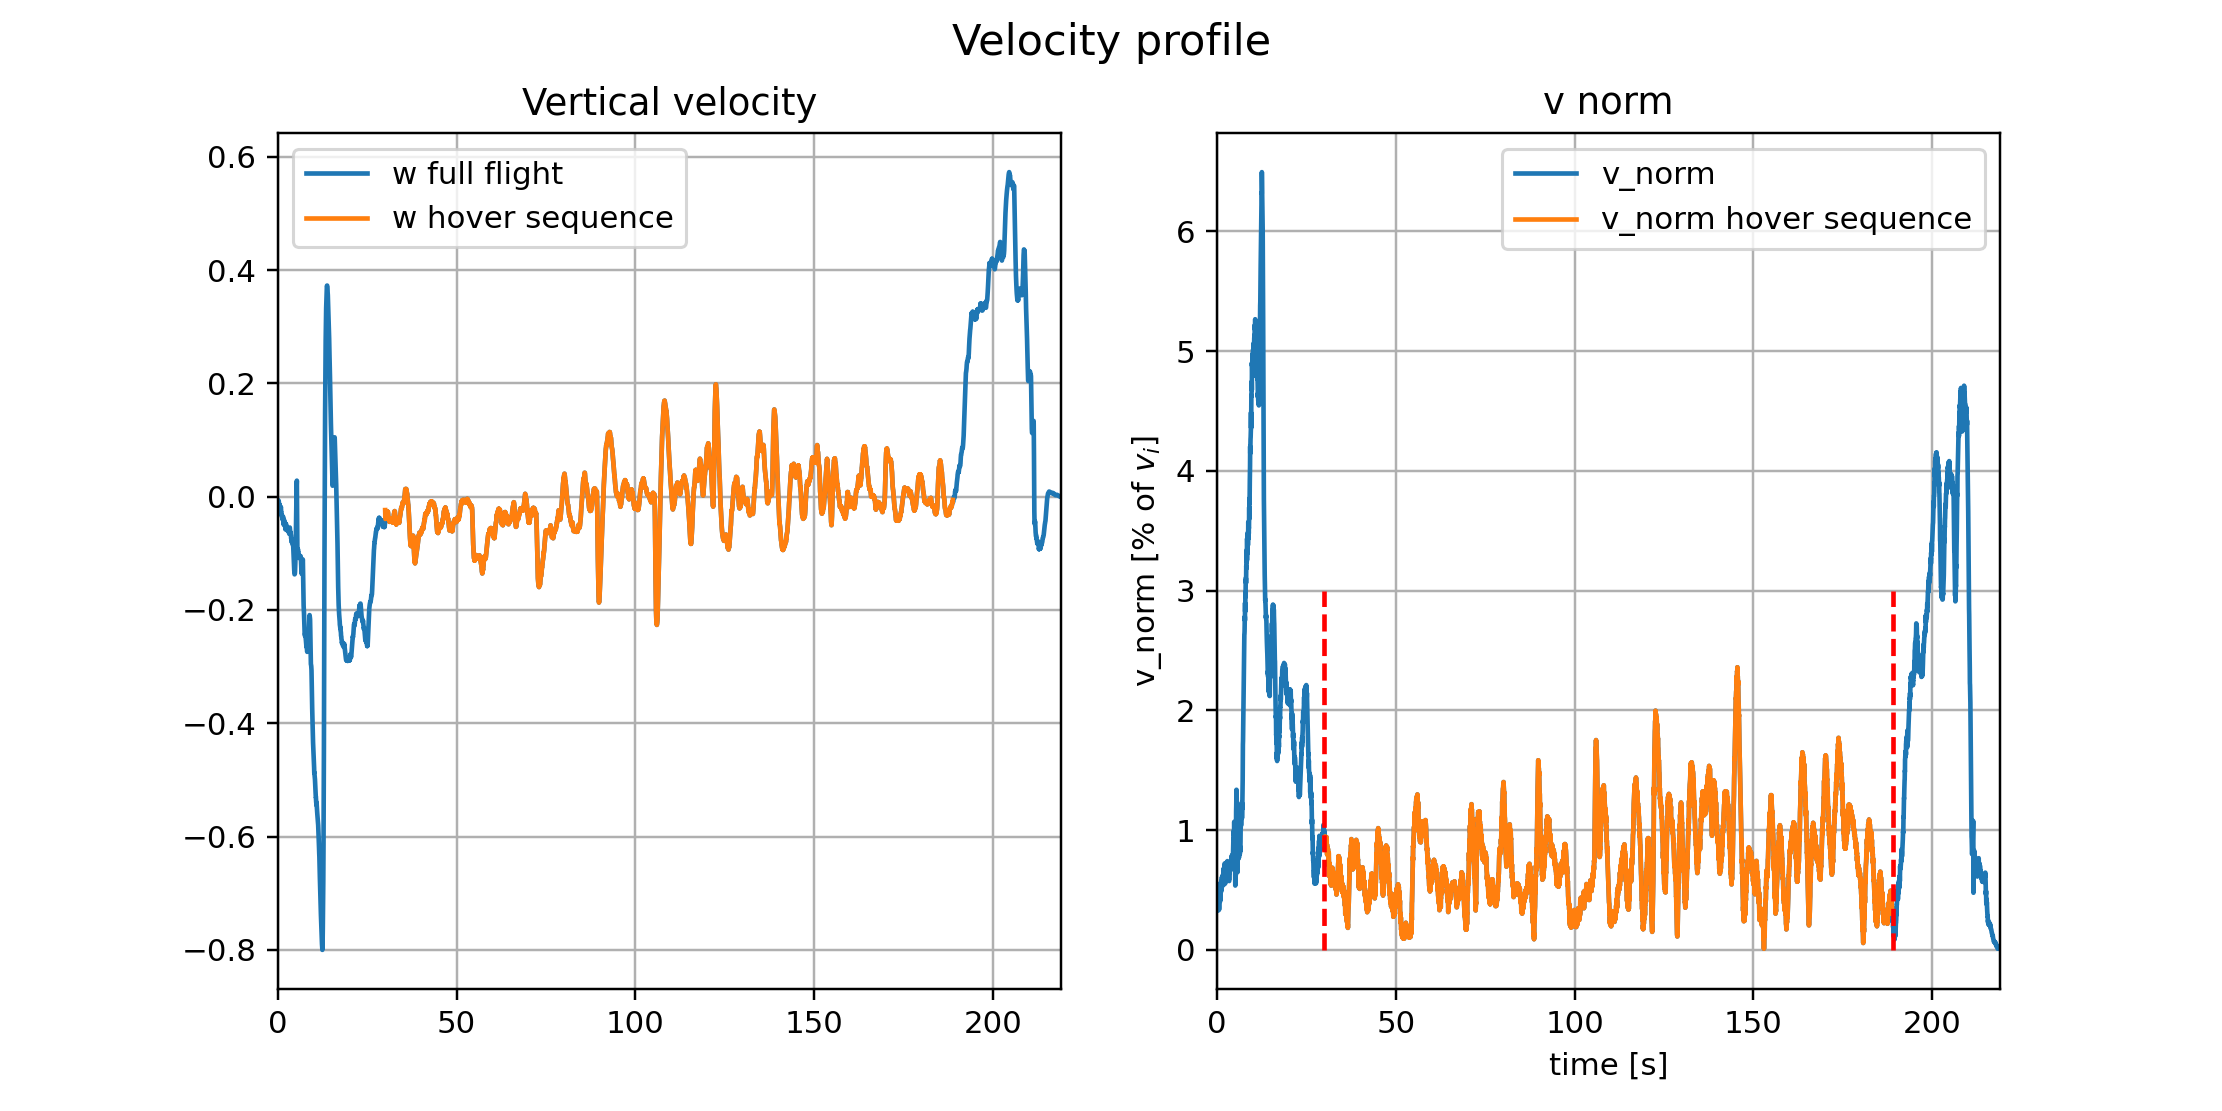

(0.0, 218.947049)

In [43]:
# plot histogram of vnorm with corresponding limit

fig0, ax0 = plt.subplots(1, 2, figsize=(10,5))
fig0.suptitle('Velocity profile', fontsize=14)

# vnorm in percentage of v_i
v_norm_percentage = (v_norm/v_induced)*100  

# plot moving average of vertical velocity w and highlight the hovering sequence
ax0[0].plot(time, moving_average(w), label='w full flight')
ax0[0].plot(time[hover], moving_average(w[hover]), label='w hover sequence')
#ax0[0].plot(time[hover_new], moving_average(w[hover_new]), label='w hover outlier')

# plot v_norm and hightlight hover sequence
ax0[1].plot(time, v_norm_percentage, label='v_norm')
ax0[1].plot(time[hover], v_norm_percentage[hover], label='v_norm hover sequence')

# add red boundary lines to highlight separation between take-off/landing and hovering
ax0[1].plot([hover_start, hover_start],[0, 3], 'r--')
ax0[1].plot([max(time)-hover_end, max(time)-hover_end],[0, 3], 'r--')

# add grid, legend, labels, etc.
ax0[0].grid()
ax0[0].legend()
ax0[0].set_title('Vertical velocity')
ax0[0].set_xlim(min(time), max(time))

ax0[1].set_title('v norm')
ax0[1].set_xlabel('time [s]')
ax0[1].set_ylabel('v_norm [% of $v_i$]')
ax0[1].grid()
ax0[1].legend()
ax0[1].set_xlim(min(time),max(time))


<IPython.core.display.Javascript object>


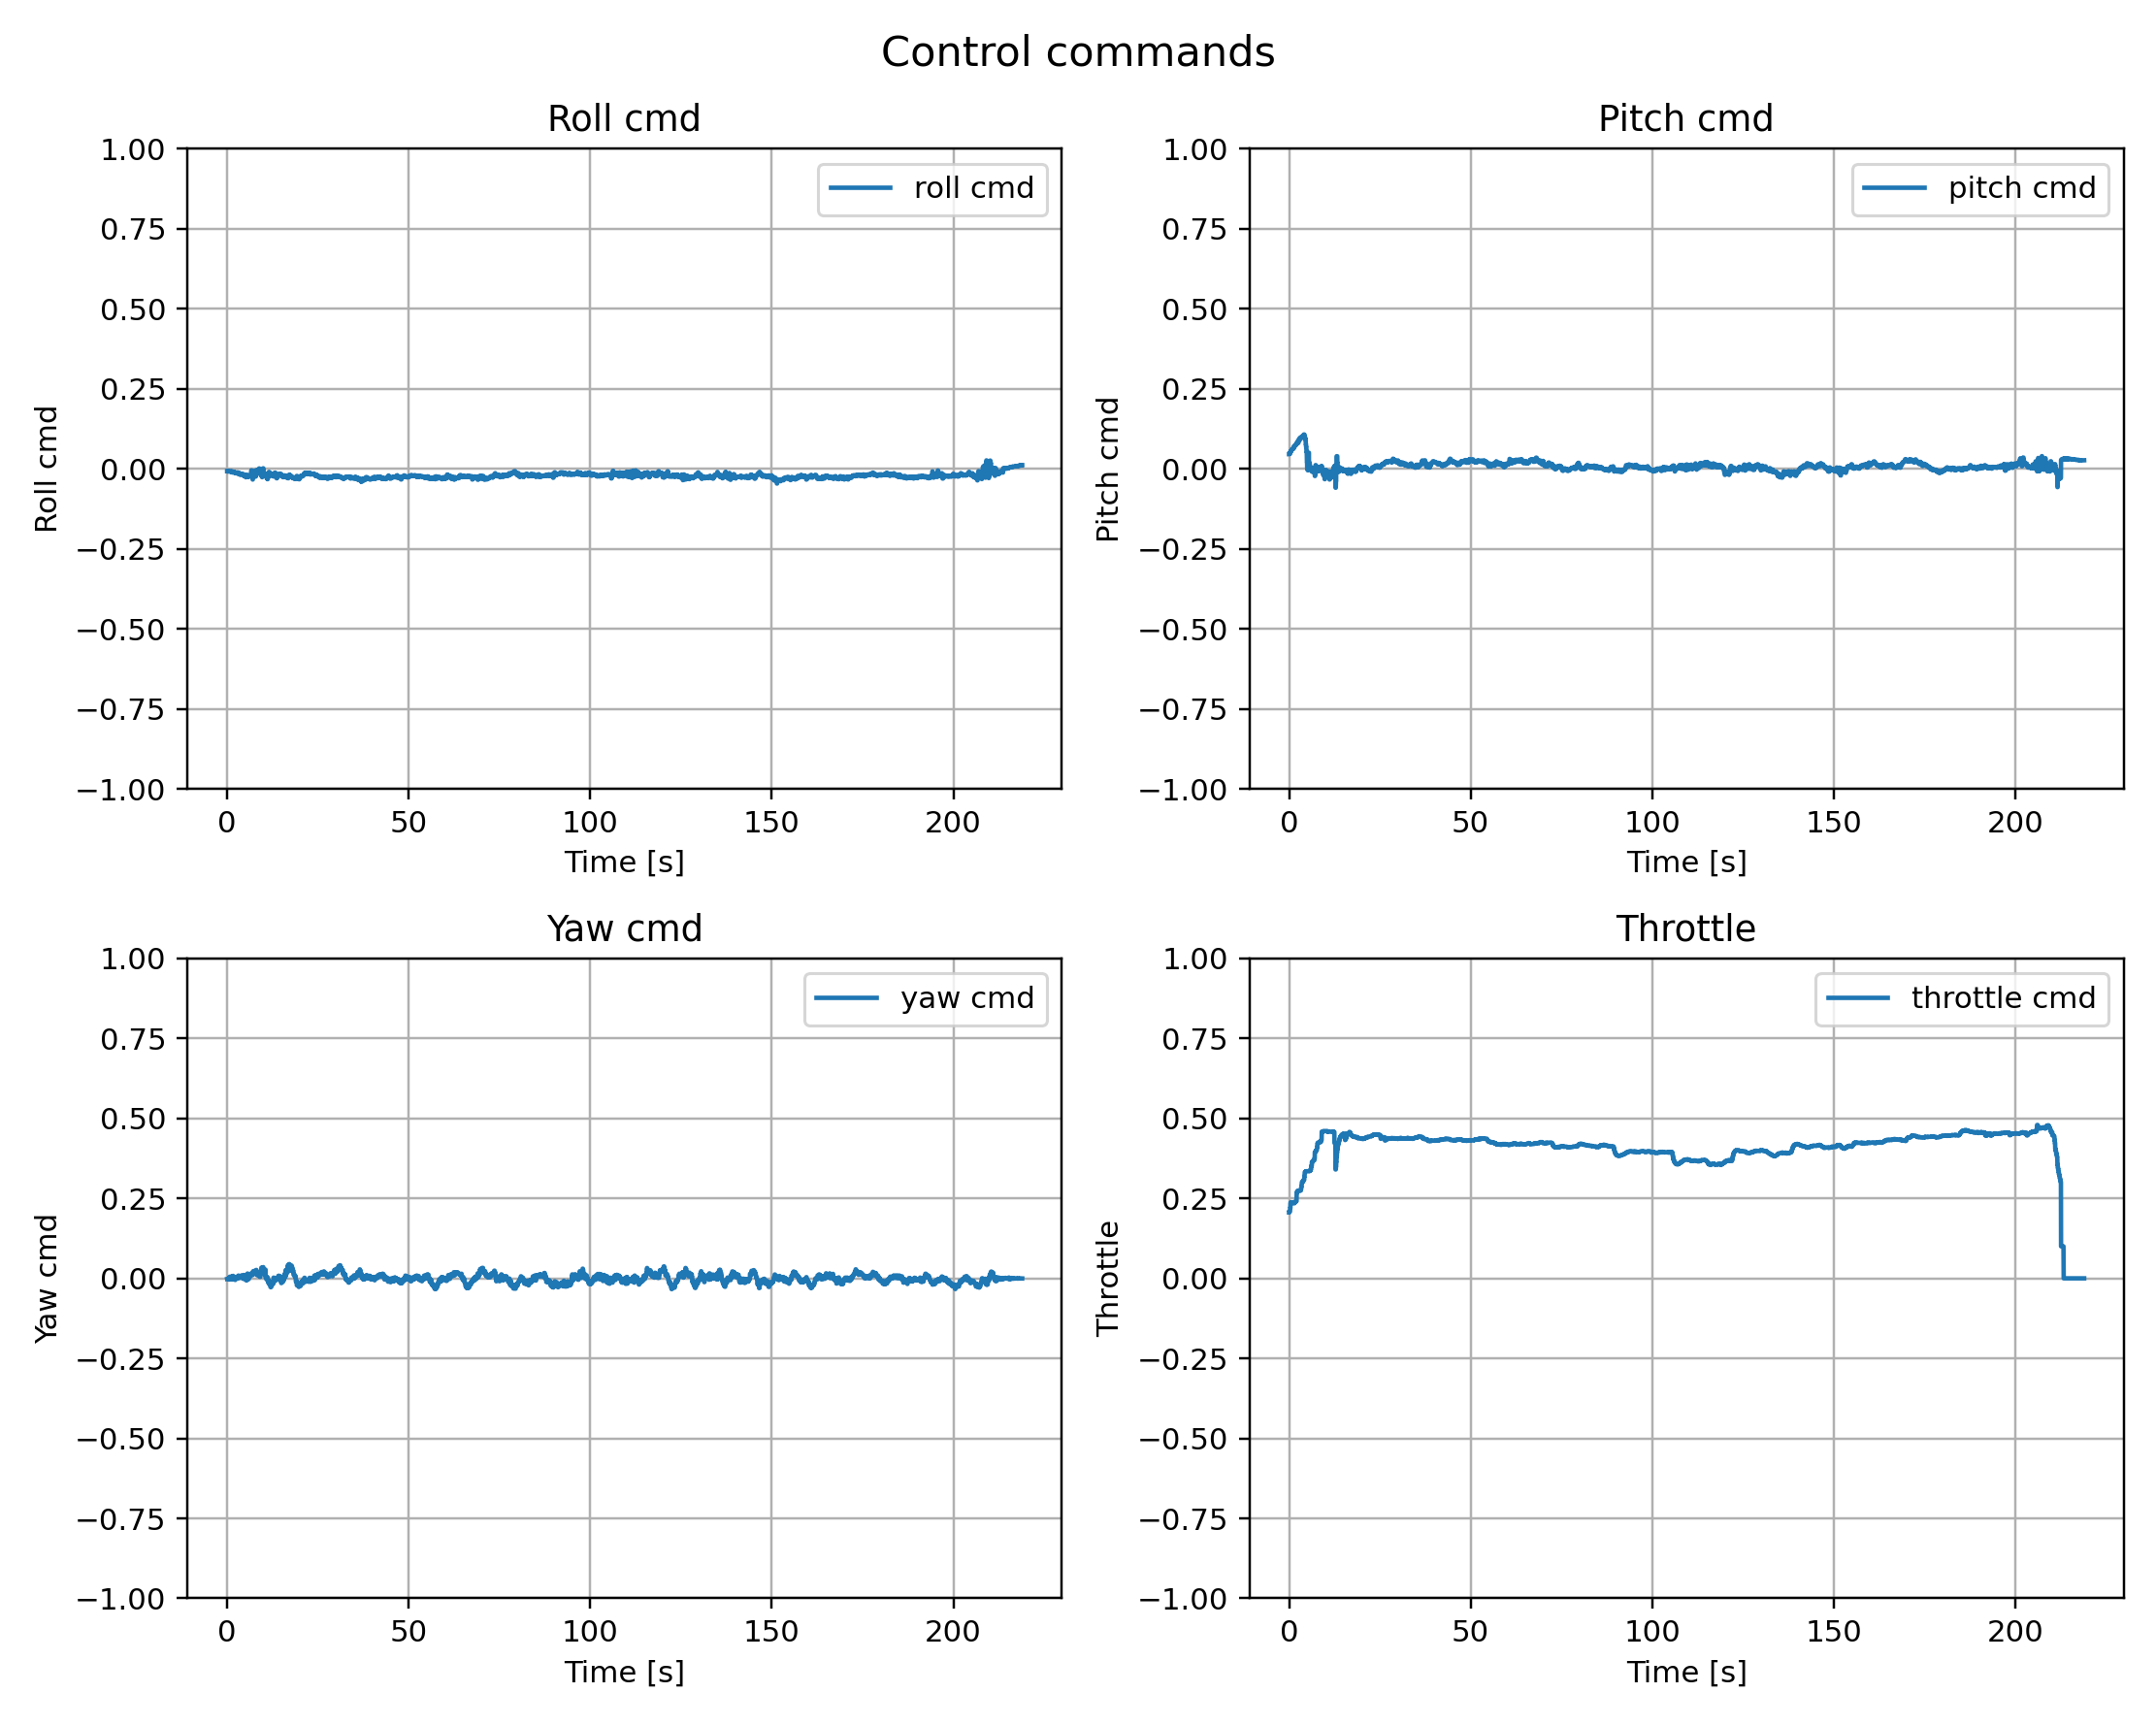

In [44]:
# Plot control commands

fig1, ax1 = plt.subplots(2, 2, figsize=(10,8))
fig1.suptitle('Control commands', fontsize=14)

ax1[0][0].plot(time,control[0], label='roll cmd')
ax1[0][1].plot(time,control[1], label='pitch cmd')
ax1[1][0].plot(time,control[2], label='yaw cmd')
ax1[1][1].plot(time,control[3], label='throttle cmd')

for i in range(2):
    for j in range(2):
        ax1[i][j].set_xlabel('Time [s]')
        ax1[i][j].set_ylim(-1,1)
        ax1[i][j].grid()
        ax1[i][j].legend()

ax1[0][0].set_ylabel(f'Roll cmd')
ax1[0][1].set_ylabel(f'Pitch cmd')
ax1[1][0].set_ylabel(f'Yaw cmd')
ax1[1][1].set_ylabel(f'Throttle')

ax1[0][0].set_title(f'Roll cmd')
ax1[0][1].set_title(f'Pitch cmd')
ax1[1][0].set_title(f'Yaw cmd')
ax1[1][1].set_title(f'Throttle')

fig1.tight_layout()

In [45]:
# Calculate motor cmds

# build control inout vector
ctrl_input = np.array([control[0].values, control[1].values, control[2].values, control[3].values,
                      np.zeros(control[0].size), np.zeros(control[0].size),
                      np.zeros(control[0].size), np.zeros(control[0].size)])

B_plus = np.array([[-1.4142,  1.4142,  2.0000, 2.0000, 0.4981, 0.0019, -0.0019, 0.0019],
              [ 1.4142,  1.4142, -2.0000, 2.0000, 0.0019, 0.4981,  0.0019,-0.0019],
              [ 1.4142, -1.4142,  2.0000, 2.0000,-0.0019, 0.0019,  0.4981, 0.0019],
              [-1.4142, -1.4142, -2.0000, 2.0000, 0.0019,-0.0019,  0.0019, 0.4981],
              [ 1.4142,  1.4142,  2.0000, 2.0000,-0.0019,-0.4981, -0.0019, 0.0019],
              [-1.4142,  1.4142, -2.0000, 2.0000,-0.4981,-0.0019,  0.0019,-0.0019],
              [-1.4142, -1.4142,  2.0000, 2.0000,-0.0019, 0.0019, -0.0019,-0.4981],
              [ 1.4142, -1.4142, -2.0000, 2.0000, 0.0019,-0.0019, -0.4981,-0.0019]])

delta_cmd = (B_plus @ ctrl_input) -1

<IPython.core.display.Javascript object>


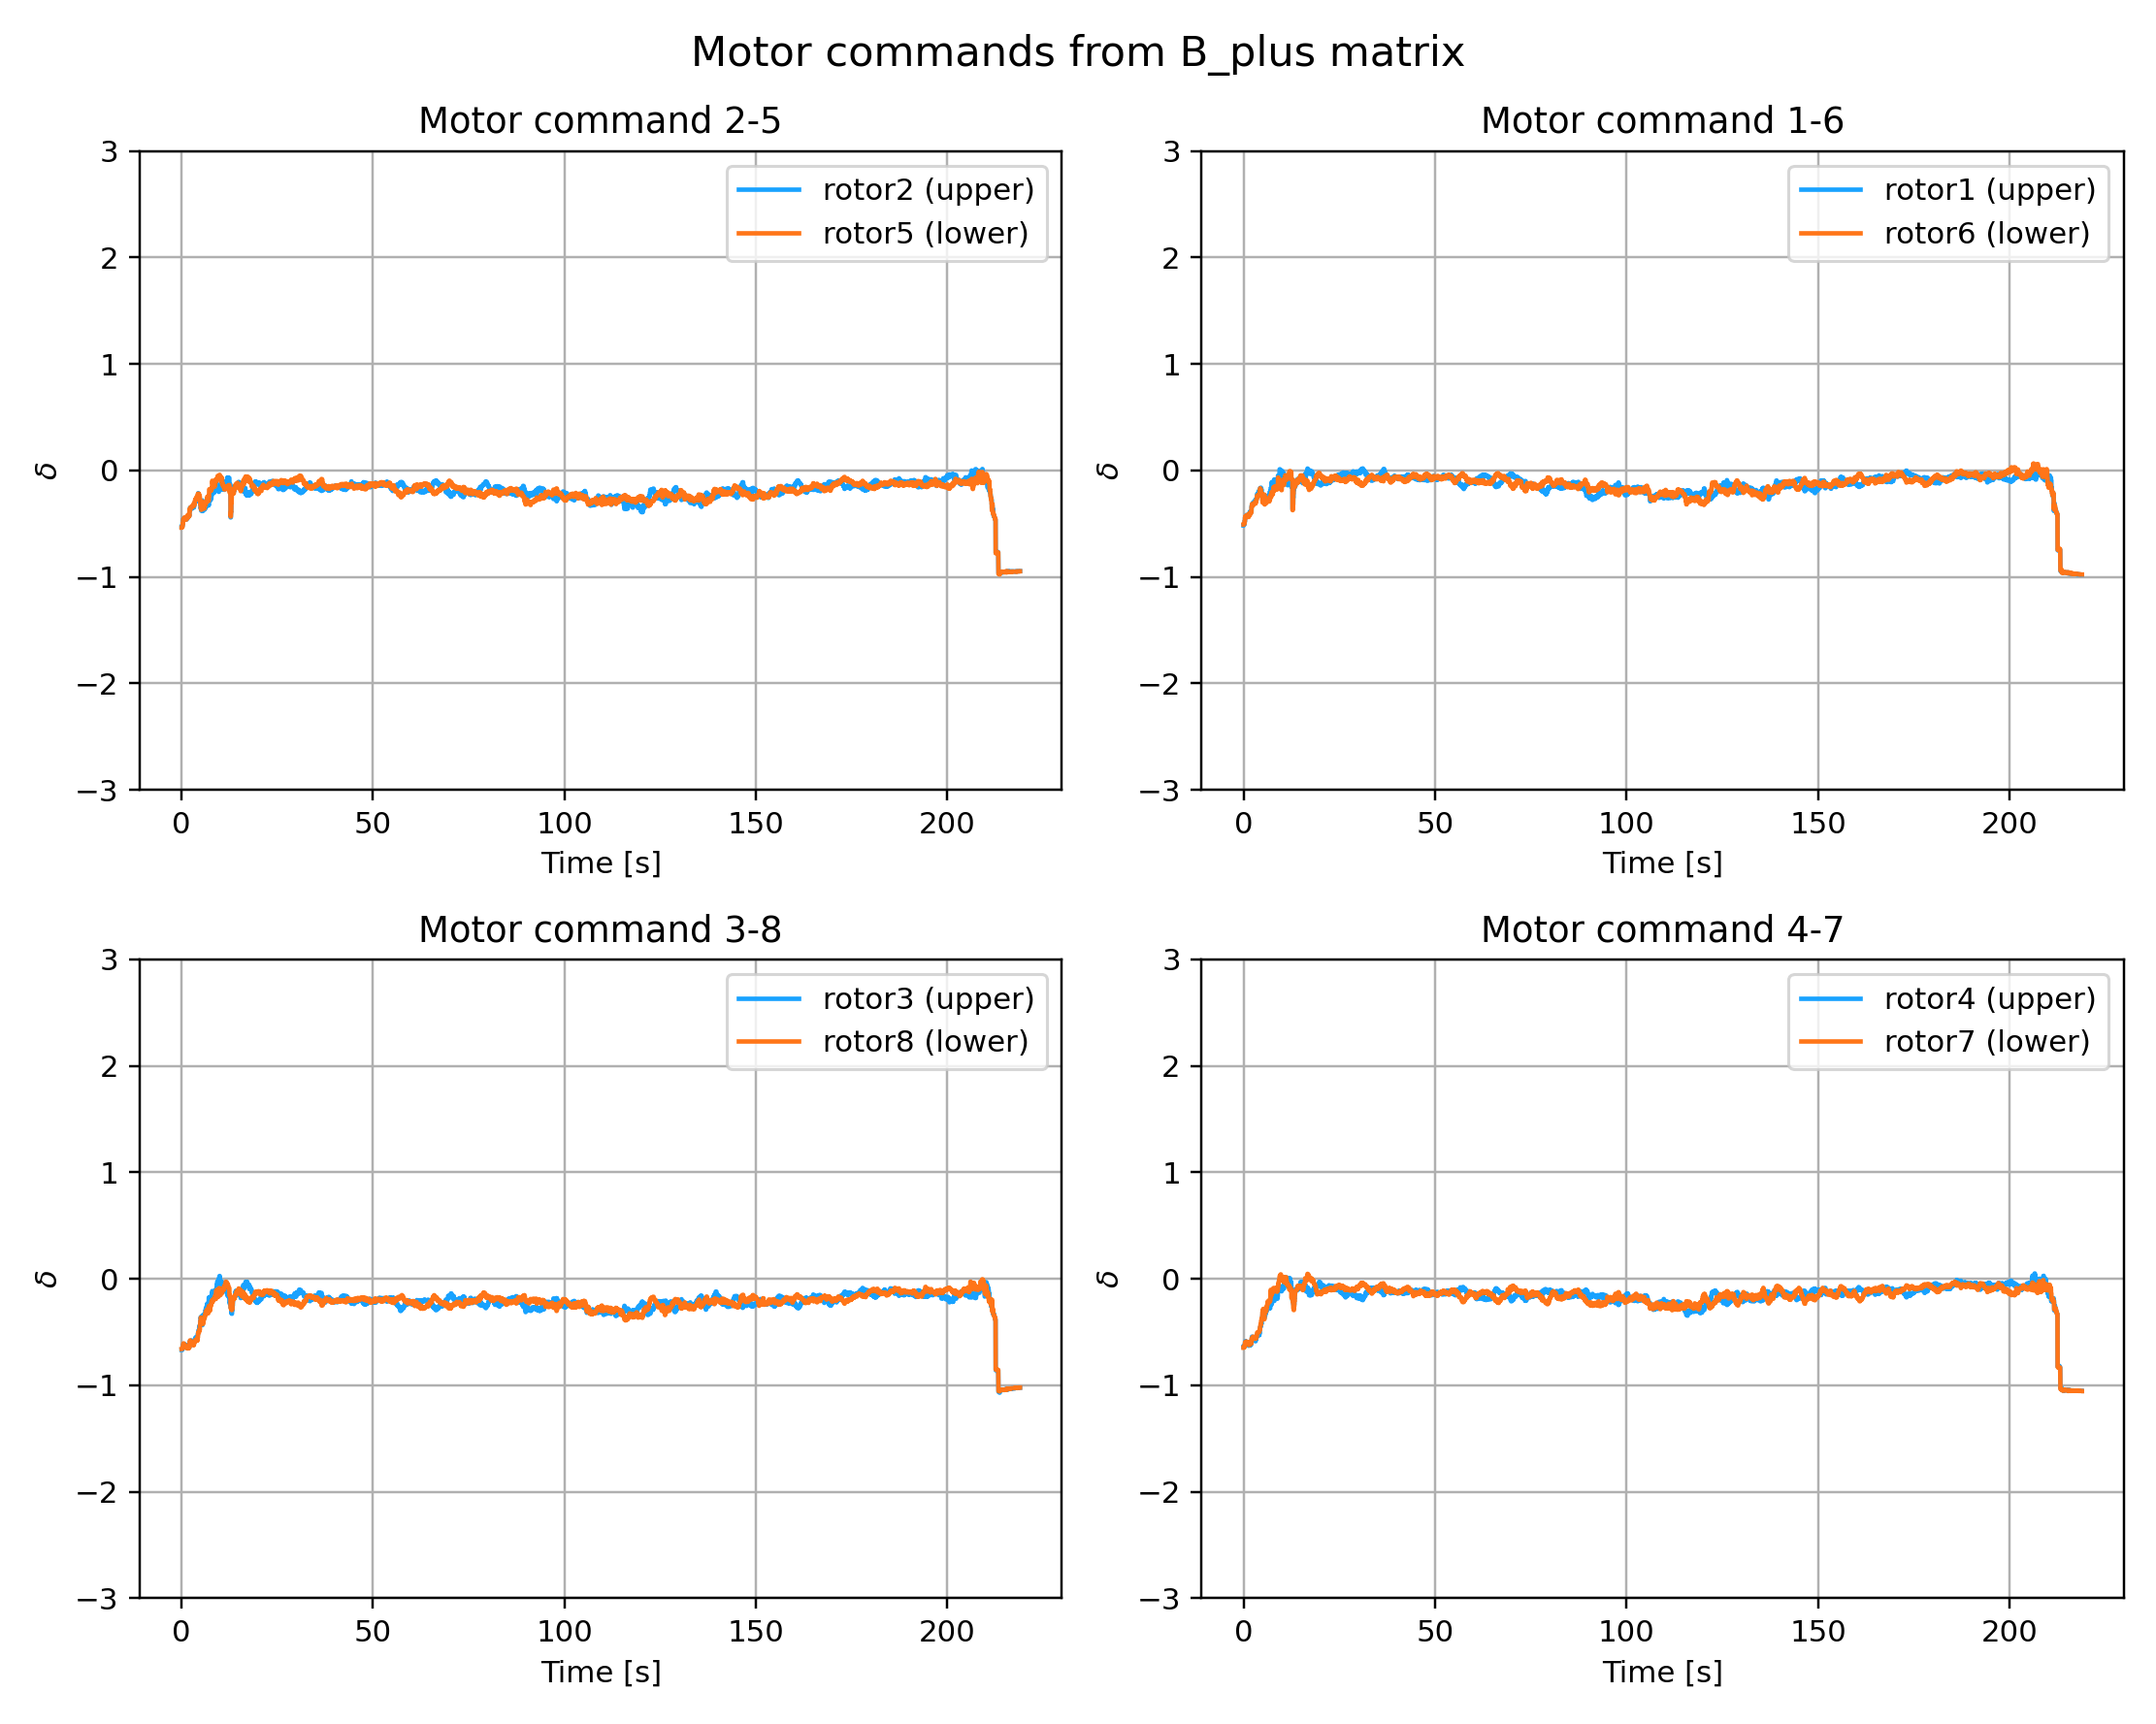

In [46]:
# Plot motor cmds

fig2, ax2 = plt.subplots(2, 2, figsize=(10,8))
fig2.suptitle('Motor commands from B_plus matrix', fontsize=14)

# Rotor pairs

ax2[0][0].plot(time,delta_cmd[1,:], color=upCol, label='rotor2 (upper)')
ax2[0][0].plot(time,delta_cmd[4,:], color=lowCol, label='rotor5 (lower)')

ax2[0][1].plot(time,delta_cmd[0,:], color=upCol, label='rotor1 (upper)')
ax2[0][1].plot(time,delta_cmd[5,:], color=lowCol, label='rotor6 (lower)')


ax2[1][0].plot(time,delta_cmd[2,:], color=upCol, label='rotor3 (upper)')
ax2[1][0].plot(time,delta_cmd[7,:], color=lowCol, label='rotor8 (lower)')

ax2[1][1].plot(time,delta_cmd[3,:], color=upCol, label='rotor4 (upper)')
ax2[1][1].plot(time,delta_cmd[6,:], color=lowCol, label='rotor7 (lower)')


for i in range(2):
    for j in range(2):
        ax2[i][j].set_xlabel('Time [s]')
        ax2[i][j].set_ylabel('$\delta$')
        ax2[i][j].set_ylim(-3,3)
        ax2[i][j].grid()
        ax2[i][j].legend()

ax2[0][0].set_title(f'Motor command 2-5')
ax2[0][1].set_title(f'Motor command 1-6')
ax2[1][0].set_title(f'Motor command 3-8')
ax2[1][1].set_title(f'Motor command 4-7')
fig2.tight_layout()

<IPython.core.display.Javascript object>


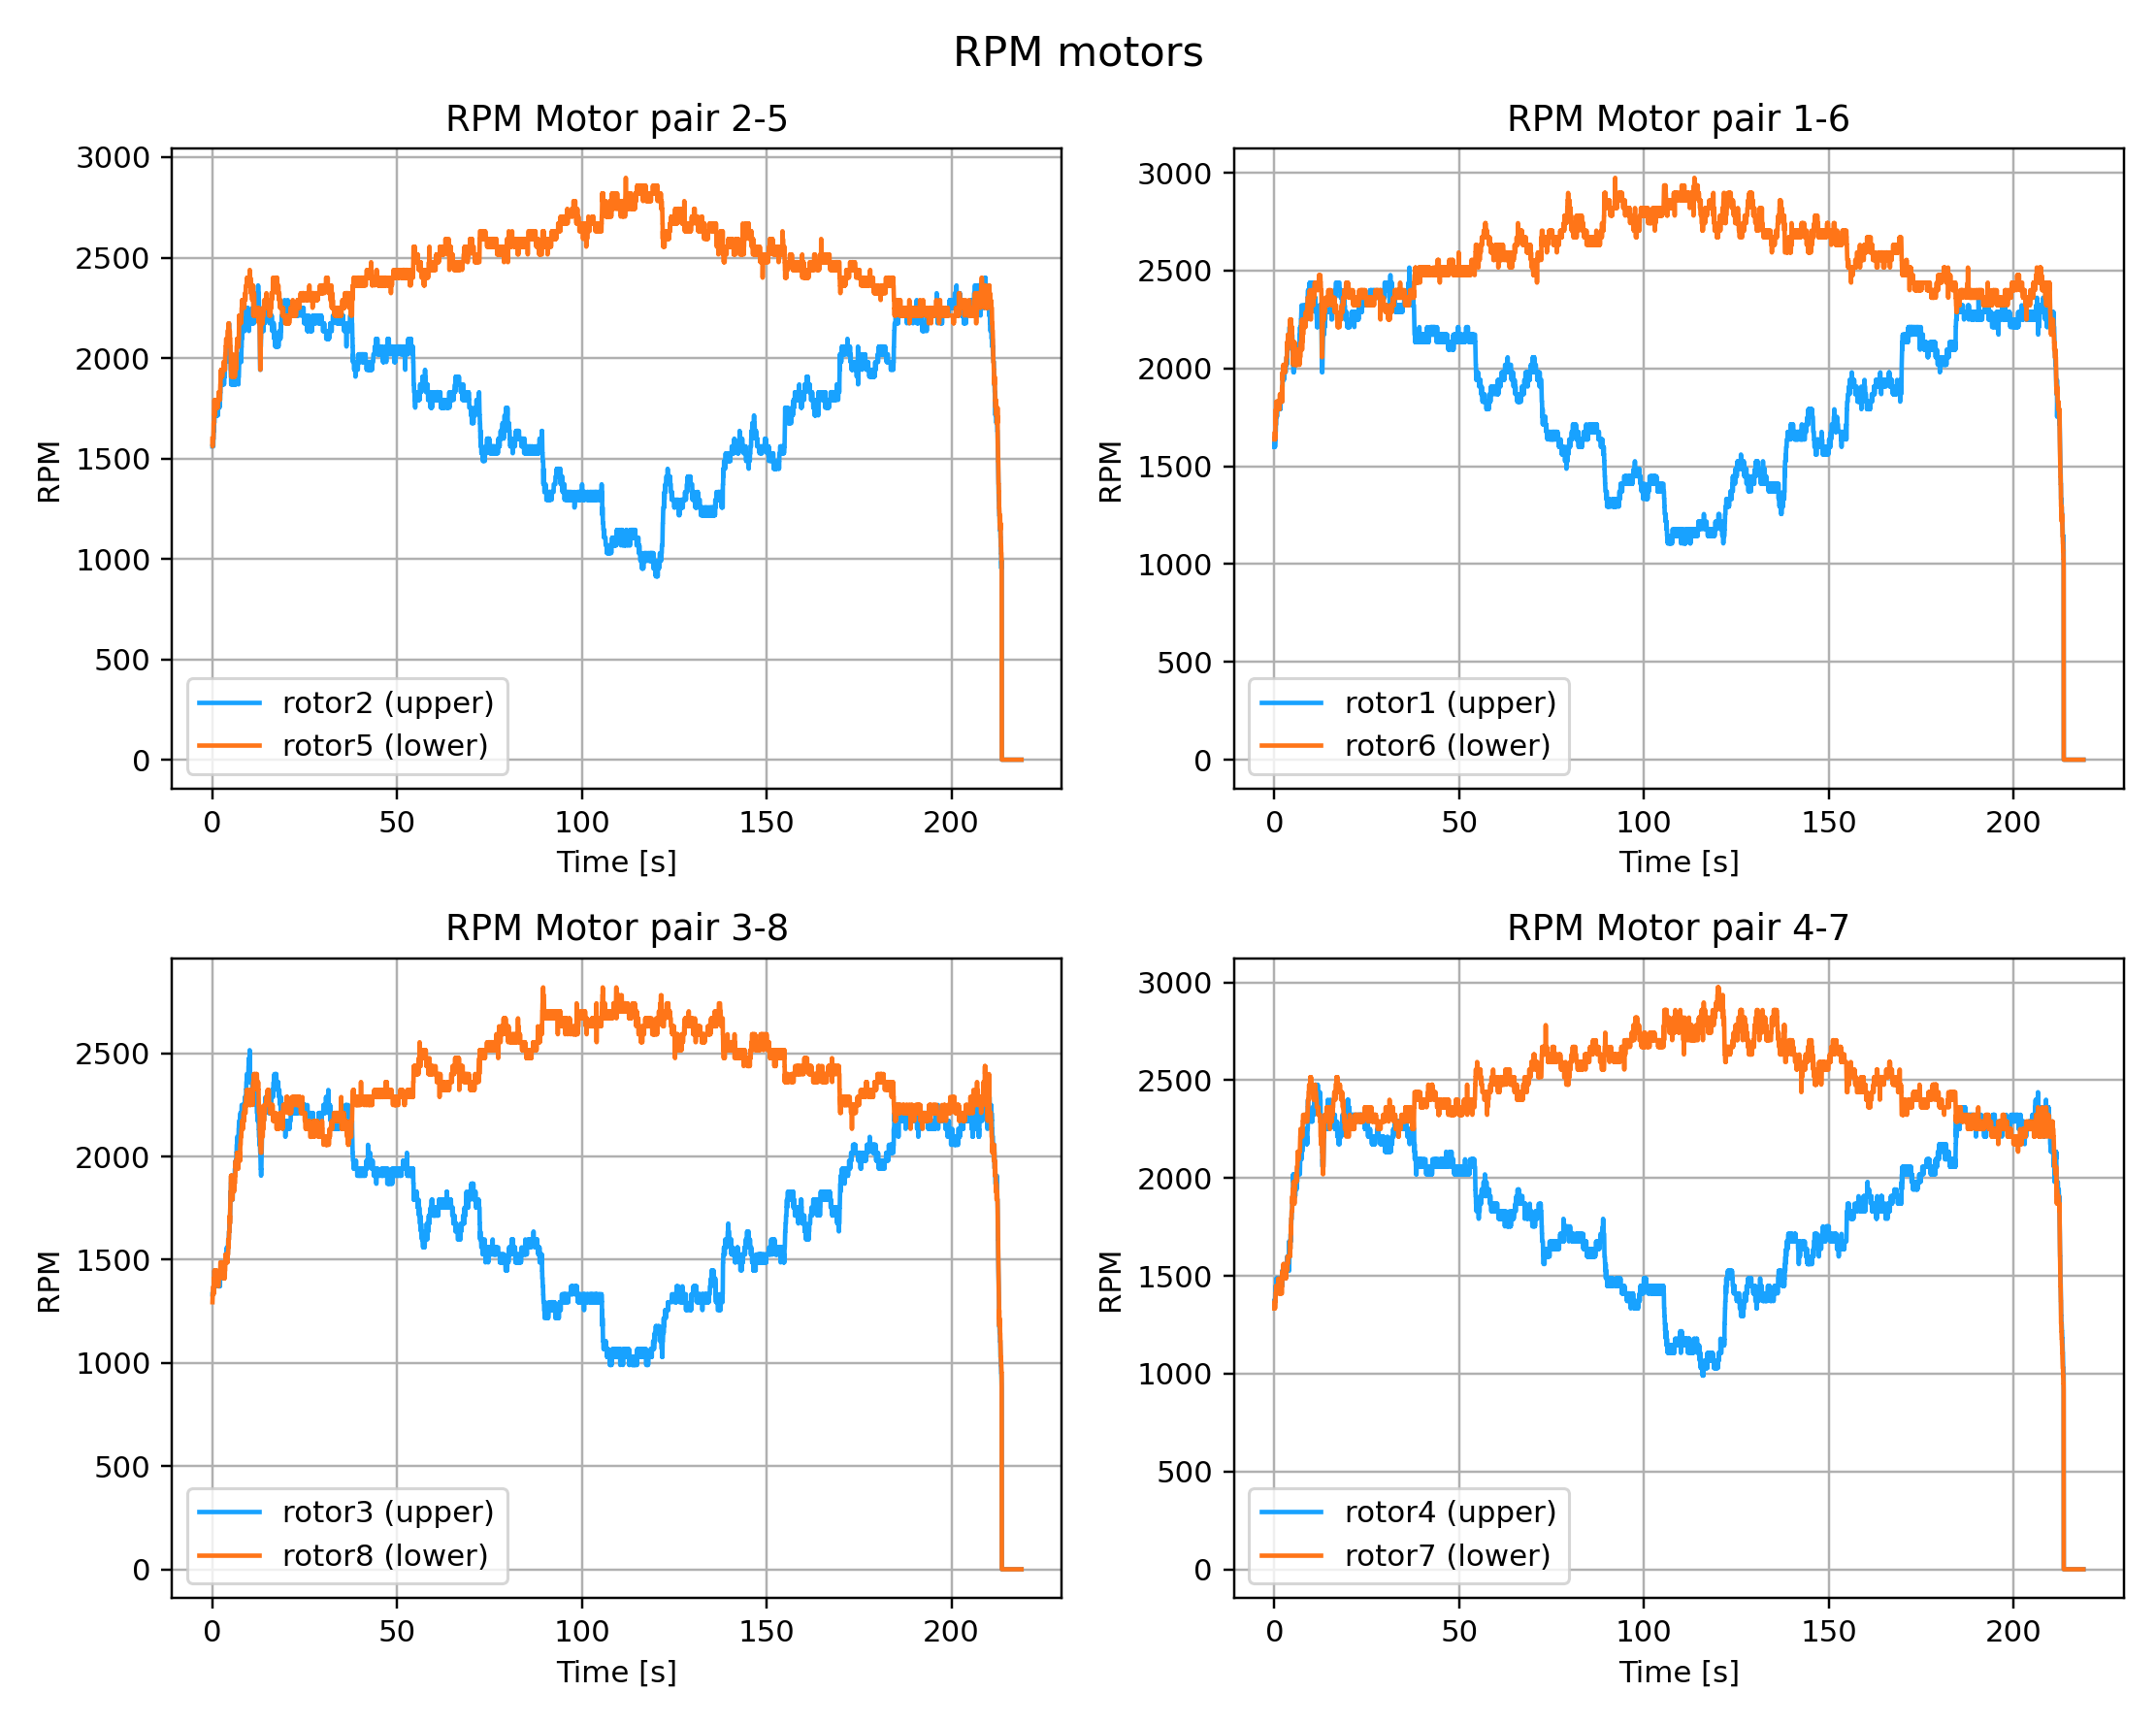

In [47]:
# Plot RPM over time

fig3, ax3 = plt.subplots(2, 2, figsize=(10,8))
fig3.suptitle('RPM motors', fontsize=14)

# Rotor pairs

ax3[0][0].plot(time,omega[1], color=upCol, label='rotor2 (upper)')
ax3[0][0].plot(time,omega[4], color=lowCol,label='rotor5 (lower)')

ax3[0][1].plot(time,omega[0], color=upCol, label='rotor1 (upper)')
ax3[0][1].plot(time,omega[5], color=lowCol, label='rotor6 (lower)')


ax3[1][0].plot(time,omega[2], color=upCol, label='rotor3 (upper)')
ax3[1][0].plot(time,omega[7], color=lowCol, label='rotor8 (lower)')

ax3[1][1].plot(time,omega[3], color=upCol, label='rotor4 (upper)')
ax3[1][1].plot(time,omega[6], color=lowCol, label='rotor7 (lower)')


for i in range(2):
    for j in range(2):
        ax3[i][j].set_xlabel('Time [s]')
        ax3[i][j].set_ylabel('RPM')
        ax3[i][j].grid()
        ax3[i][j].legend()

ax3[0][0].set_title(f'RPM Motor pair 2-5')
ax3[0][1].set_title(f'RPM Motor pair 1-6')
ax3[1][0].set_title(f'RPM Motor pair 3-8')
ax3[1][1].set_title(f'RPM Motor pair 4-7')

fig3.tight_layout()

<IPython.core.display.Javascript object>


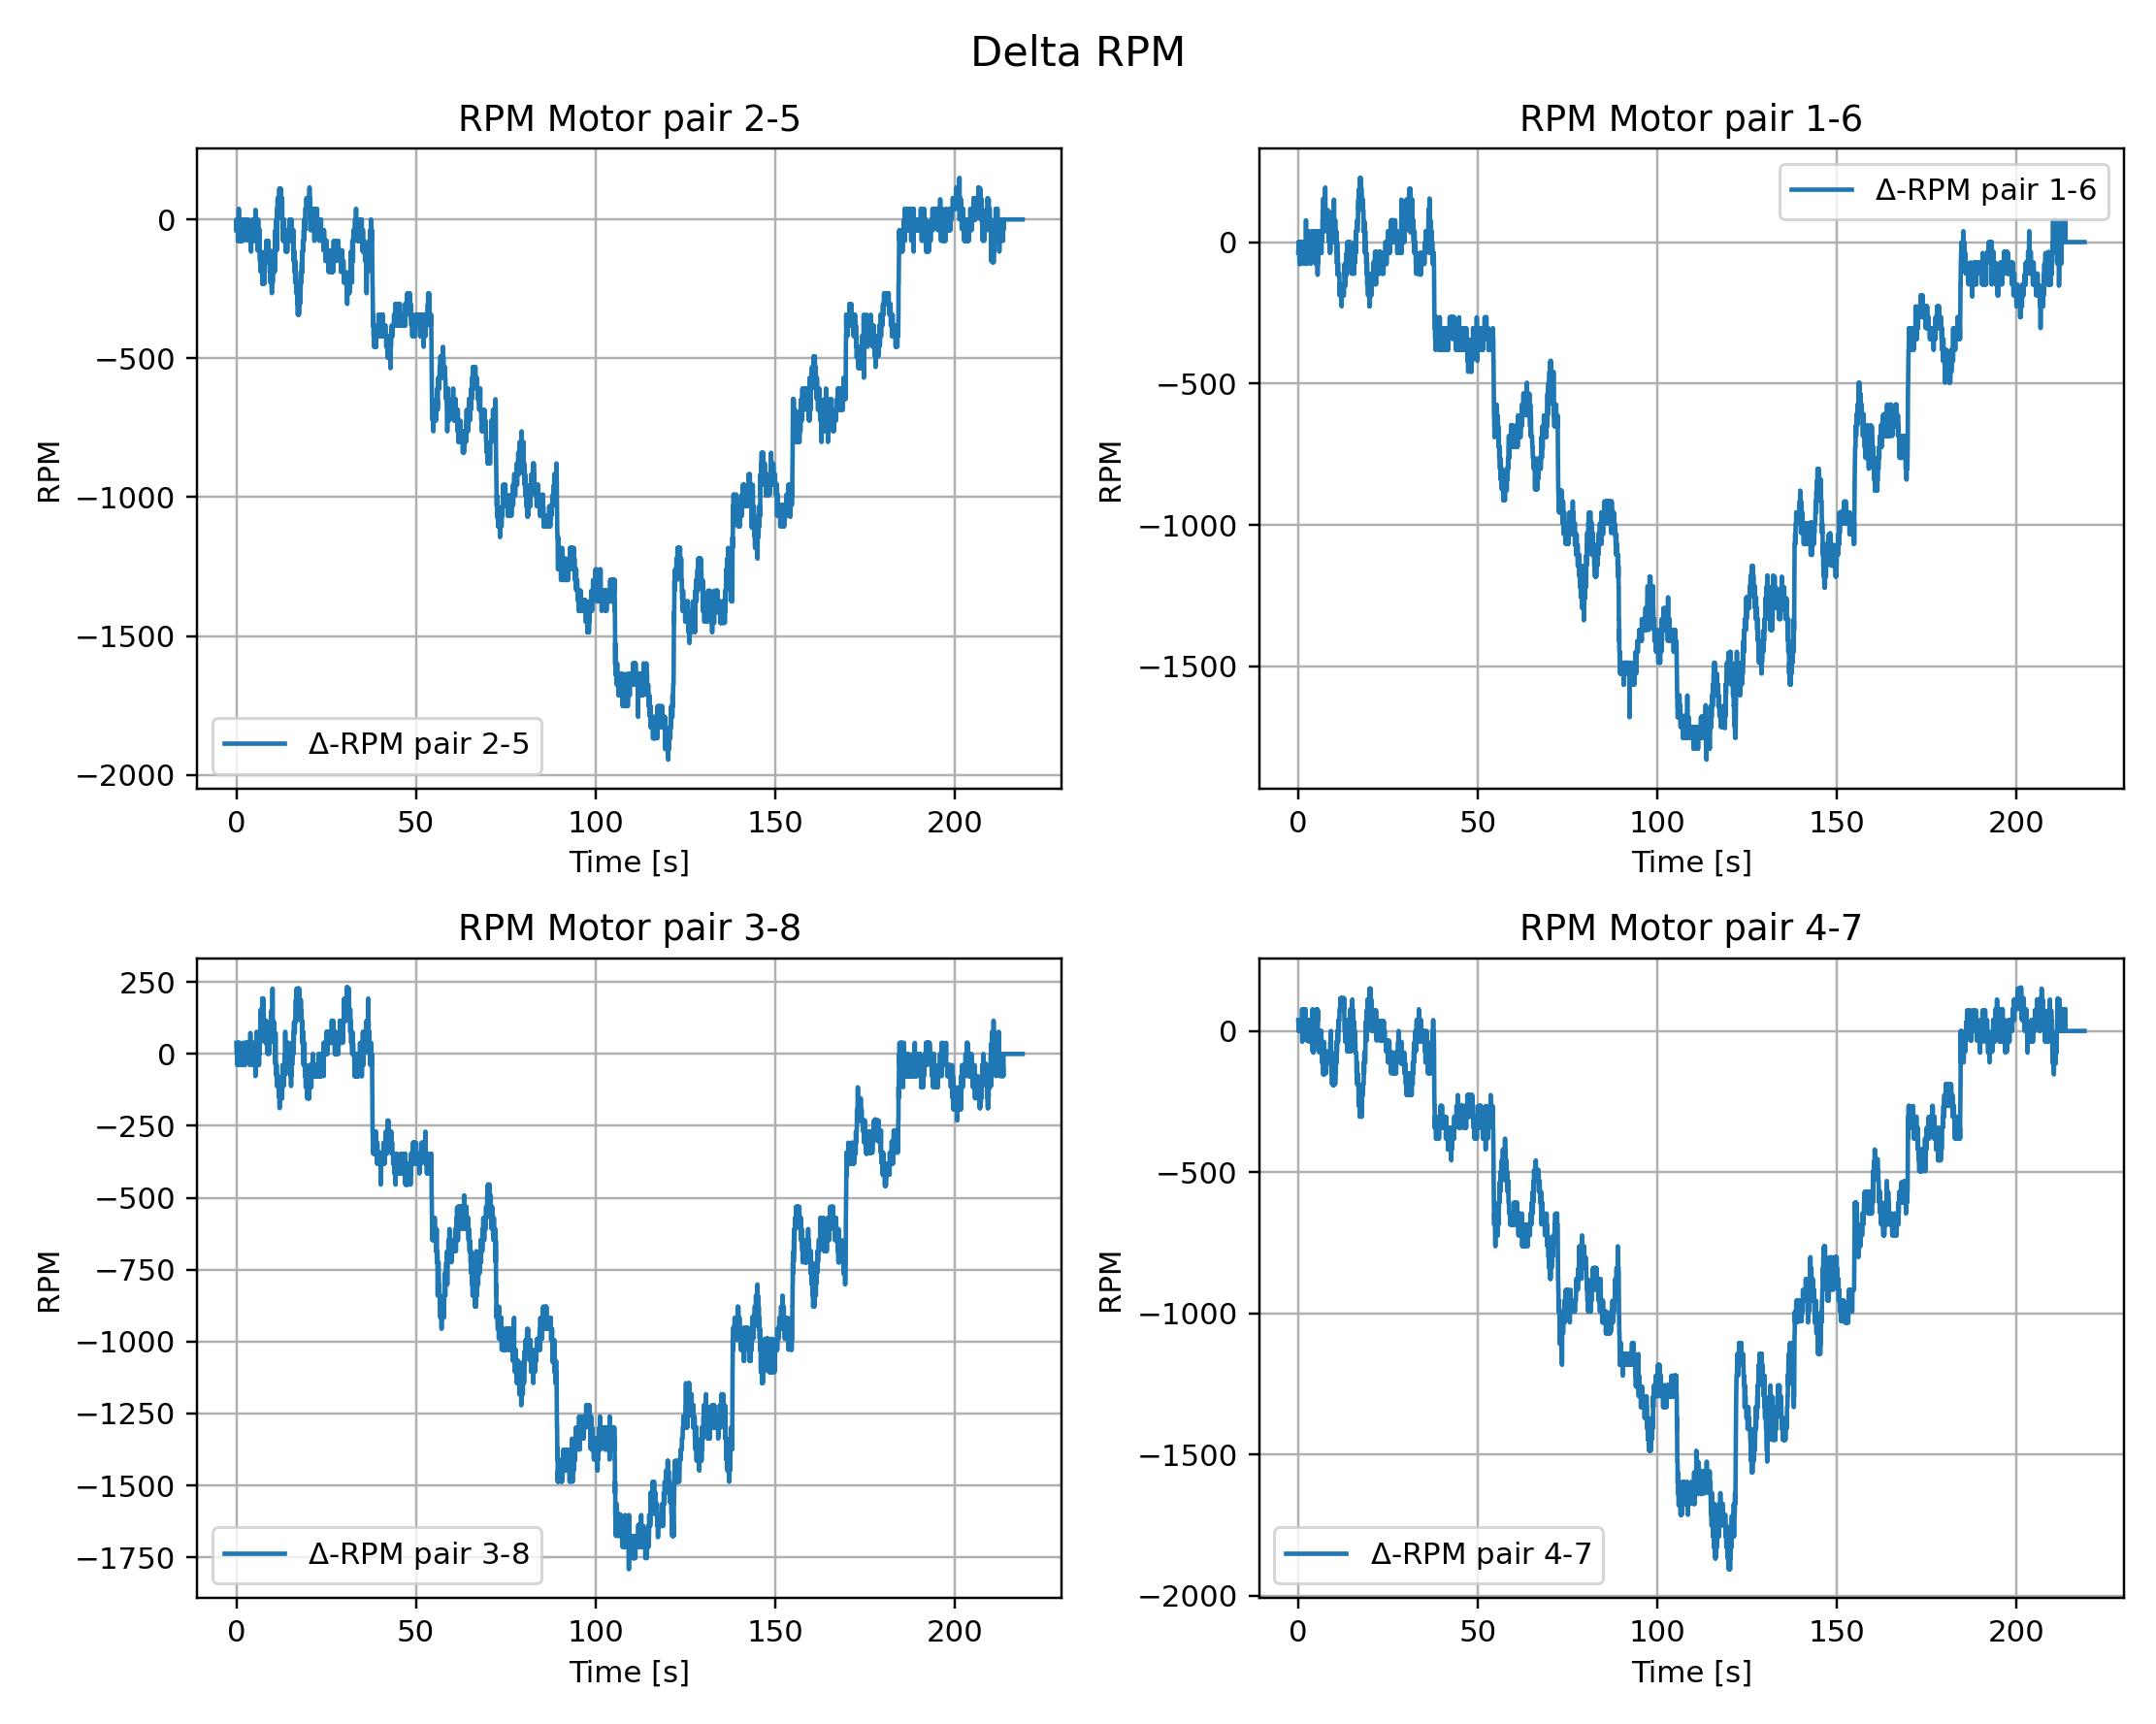

In [48]:
# delta RPM

fig4, ax4 = plt.subplots(2, 2, figsize=(10,8))
fig4.suptitle('Delta RPM', fontsize=14)

# Rotor pairs

ax4[0][0].plot(time,omega[1] - omega[4], label='$\Delta$-RPM pair 2-5')
ax4[0][1].plot(time,omega[0] - omega[5], label='$\Delta$-RPM pair 1-6')
ax4[1][0].plot(time,omega[2] - omega[7], label='$\Delta$-RPM pair 3-8')
ax4[1][1].plot(time,omega[3] - omega[6], label='$\Delta$-RPM pair 4-7')

for i in range(2):
    for j in range(2):
        ax4[i][j].set_xlabel('Time [s]')
        ax4[i][j].set_ylabel('RPM')
        ax4[i][j].grid()
        ax4[i][j].legend()

ax4[0][0].set_title(f'RPM Motor pair 2-5')
ax4[0][1].set_title(f'RPM Motor pair 1-6')
ax4[1][0].set_title(f'RPM Motor pair 3-8')
ax4[1][1].set_title(f'RPM Motor pair 4-7')

fig4.tight_layout()

<IPython.core.display.Javascript object>


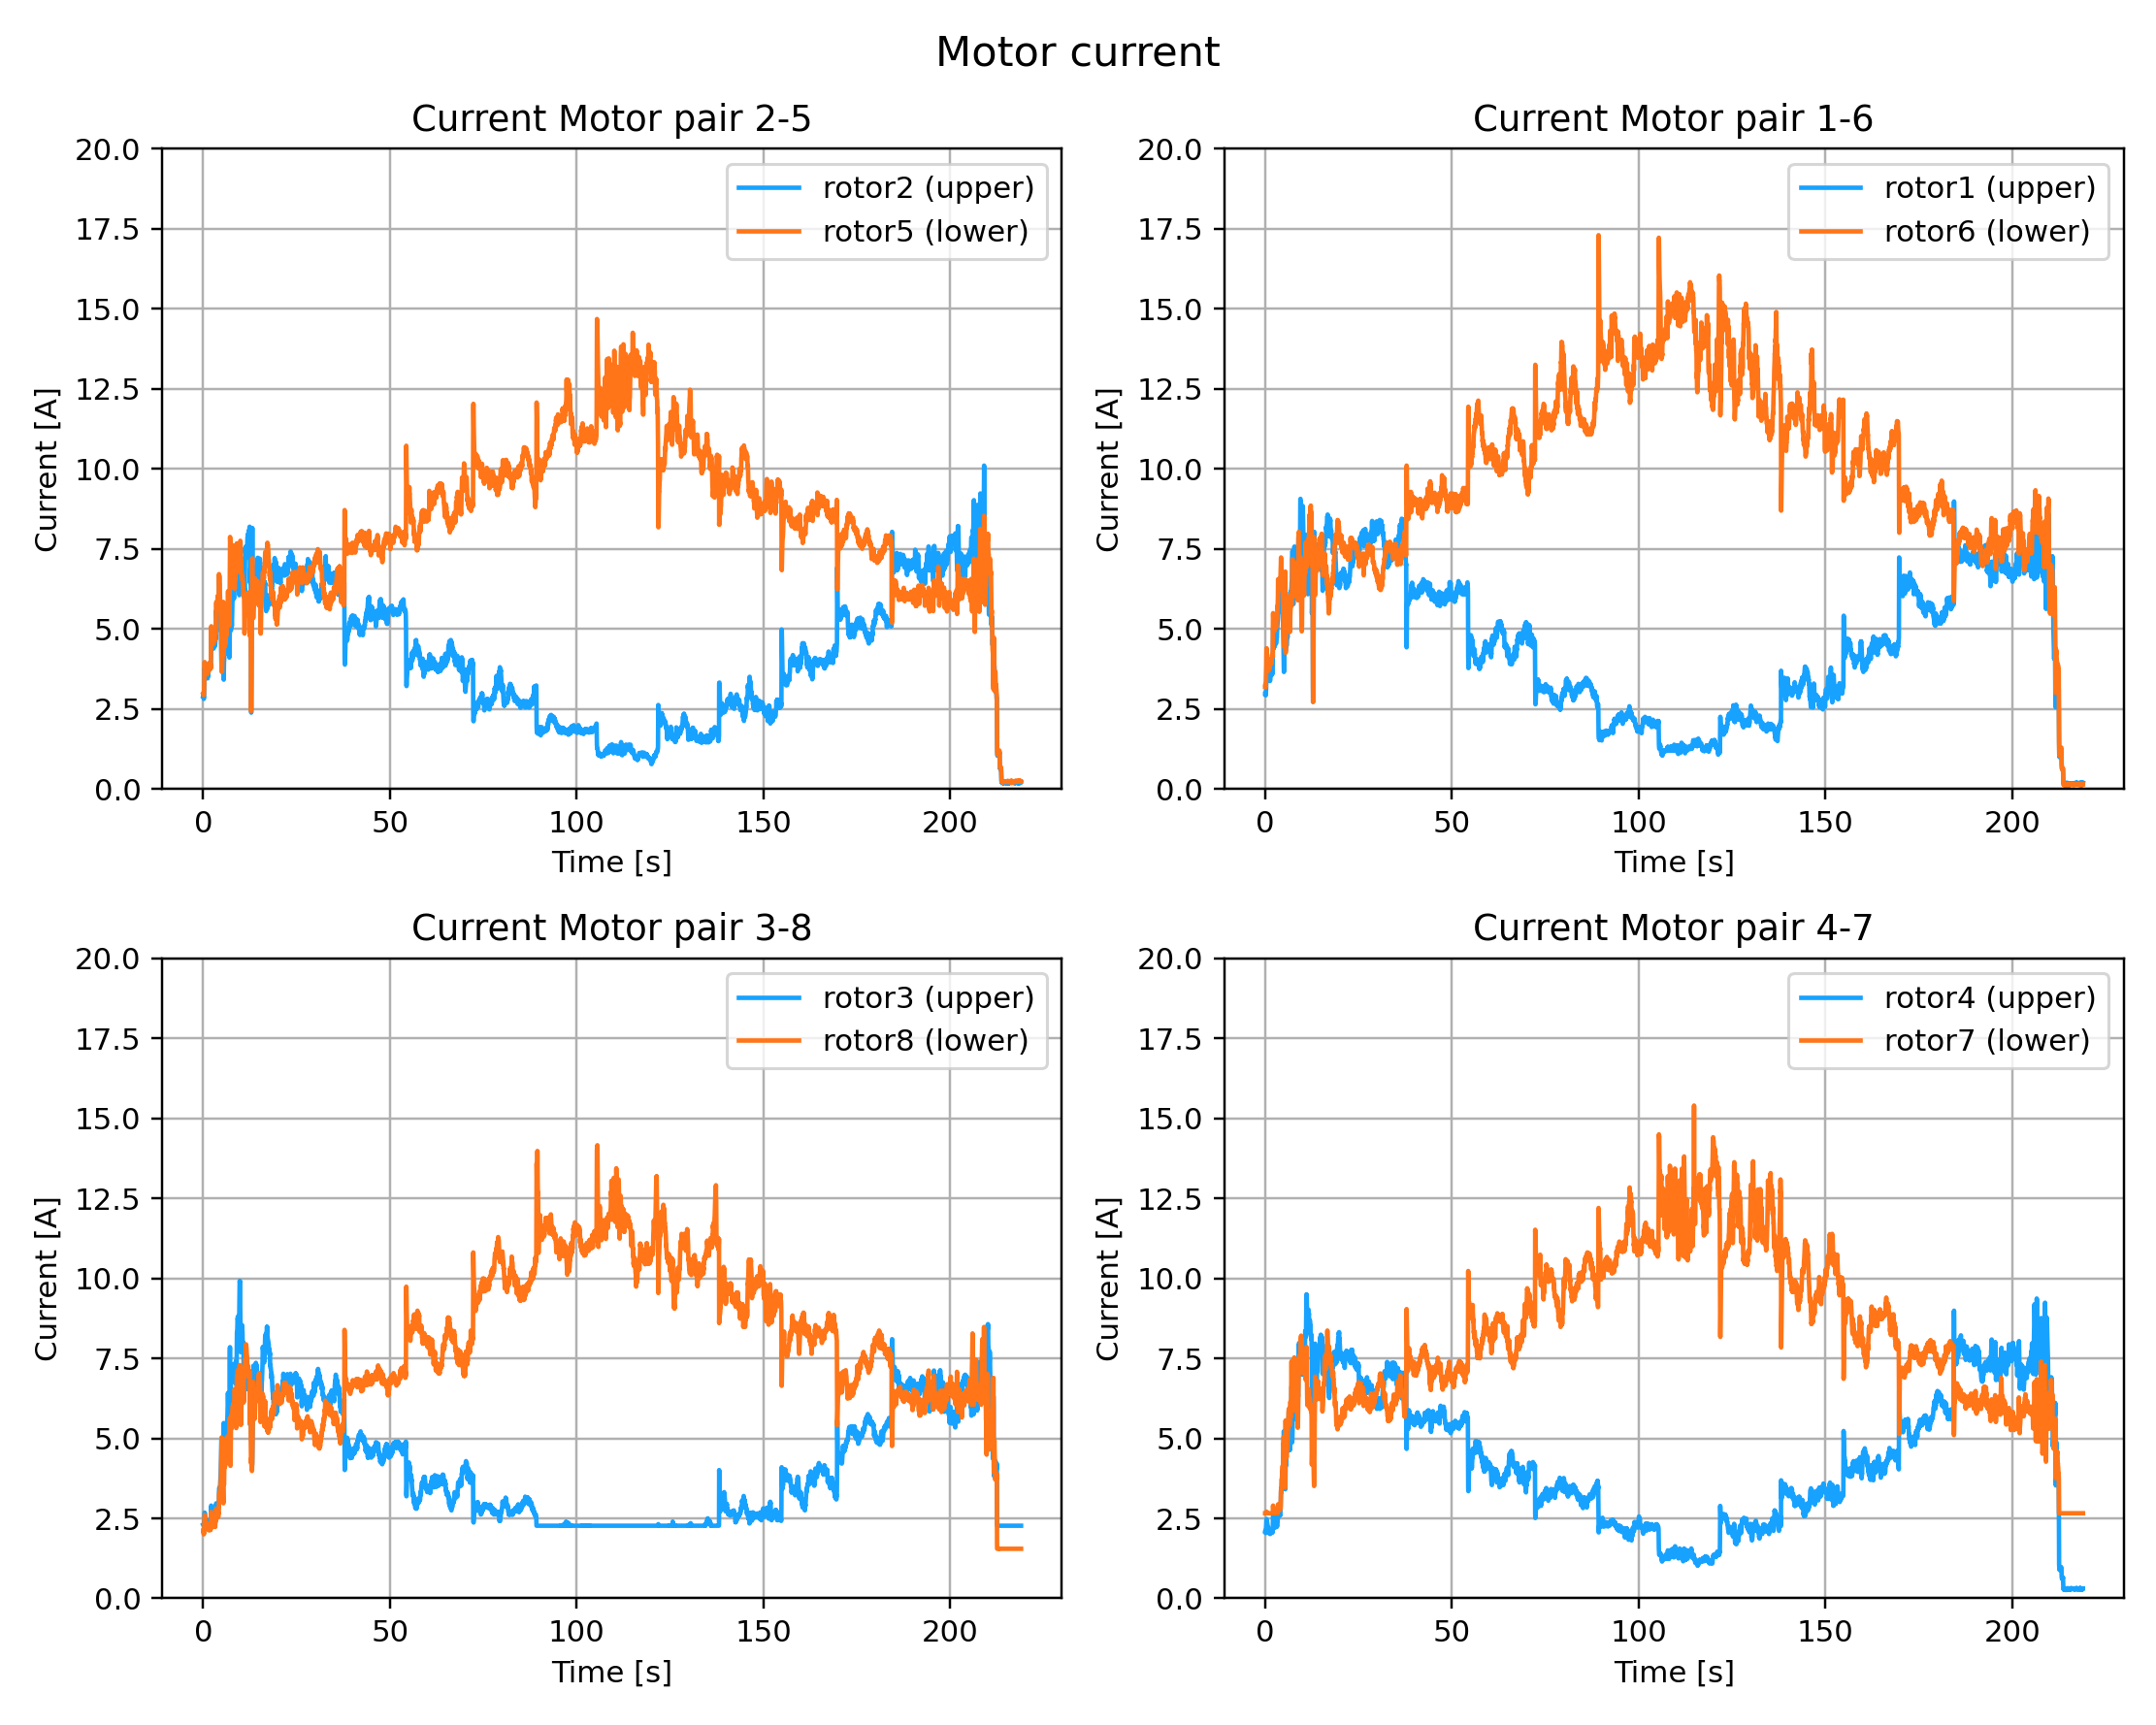

In [49]:
# Plot moor current over time

fig5, ax5 = plt.subplots(2, 2, figsize=(10,8))
fig5.suptitle('Motor current', fontsize=14)
# Rotor pairs

ax5[0][0].plot(time,current[1], color=upCol, label='rotor2 (upper)')
ax5[0][0].plot(time,current[4], color=lowCol, label='rotor5 (lower)')

ax5[0][1].plot(time,current[0], color=upCol, label='rotor1 (upper)')
ax5[0][1].plot(time,current[5], color=lowCol, label='rotor6 (lower)')


ax5[1][0].plot(time,current[2], color=upCol, label='rotor3 (upper)')
ax5[1][0].plot(time,current[7], color=lowCol, label='rotor8 (lower)')

ax5[1][1].plot(time,current[3], color=upCol, label='rotor4 (upper)')
ax5[1][1].plot(time,current[6], color=lowCol, label='rotor7 (lower)')


for i in range(2):
    for j in range(2):
        ax5[i][j].set_xlabel('Time [s]')
        ax5[i][j].set_ylabel('Current [A]')
        ax5[i][j].set_ylim(0,20)
        ax5[i][j].grid()
        ax5[i][j].legend()

ax5[0][0].set_title(f'Current Motor pair 2-5')
ax5[0][1].set_title(f'Current Motor pair 1-6')
ax5[1][0].set_title(f'Current Motor pair 3-8')
ax5[1][1].set_title(f'Current Motor pair 4-7')

fig5.tight_layout()

<IPython.core.display.Javascript object>


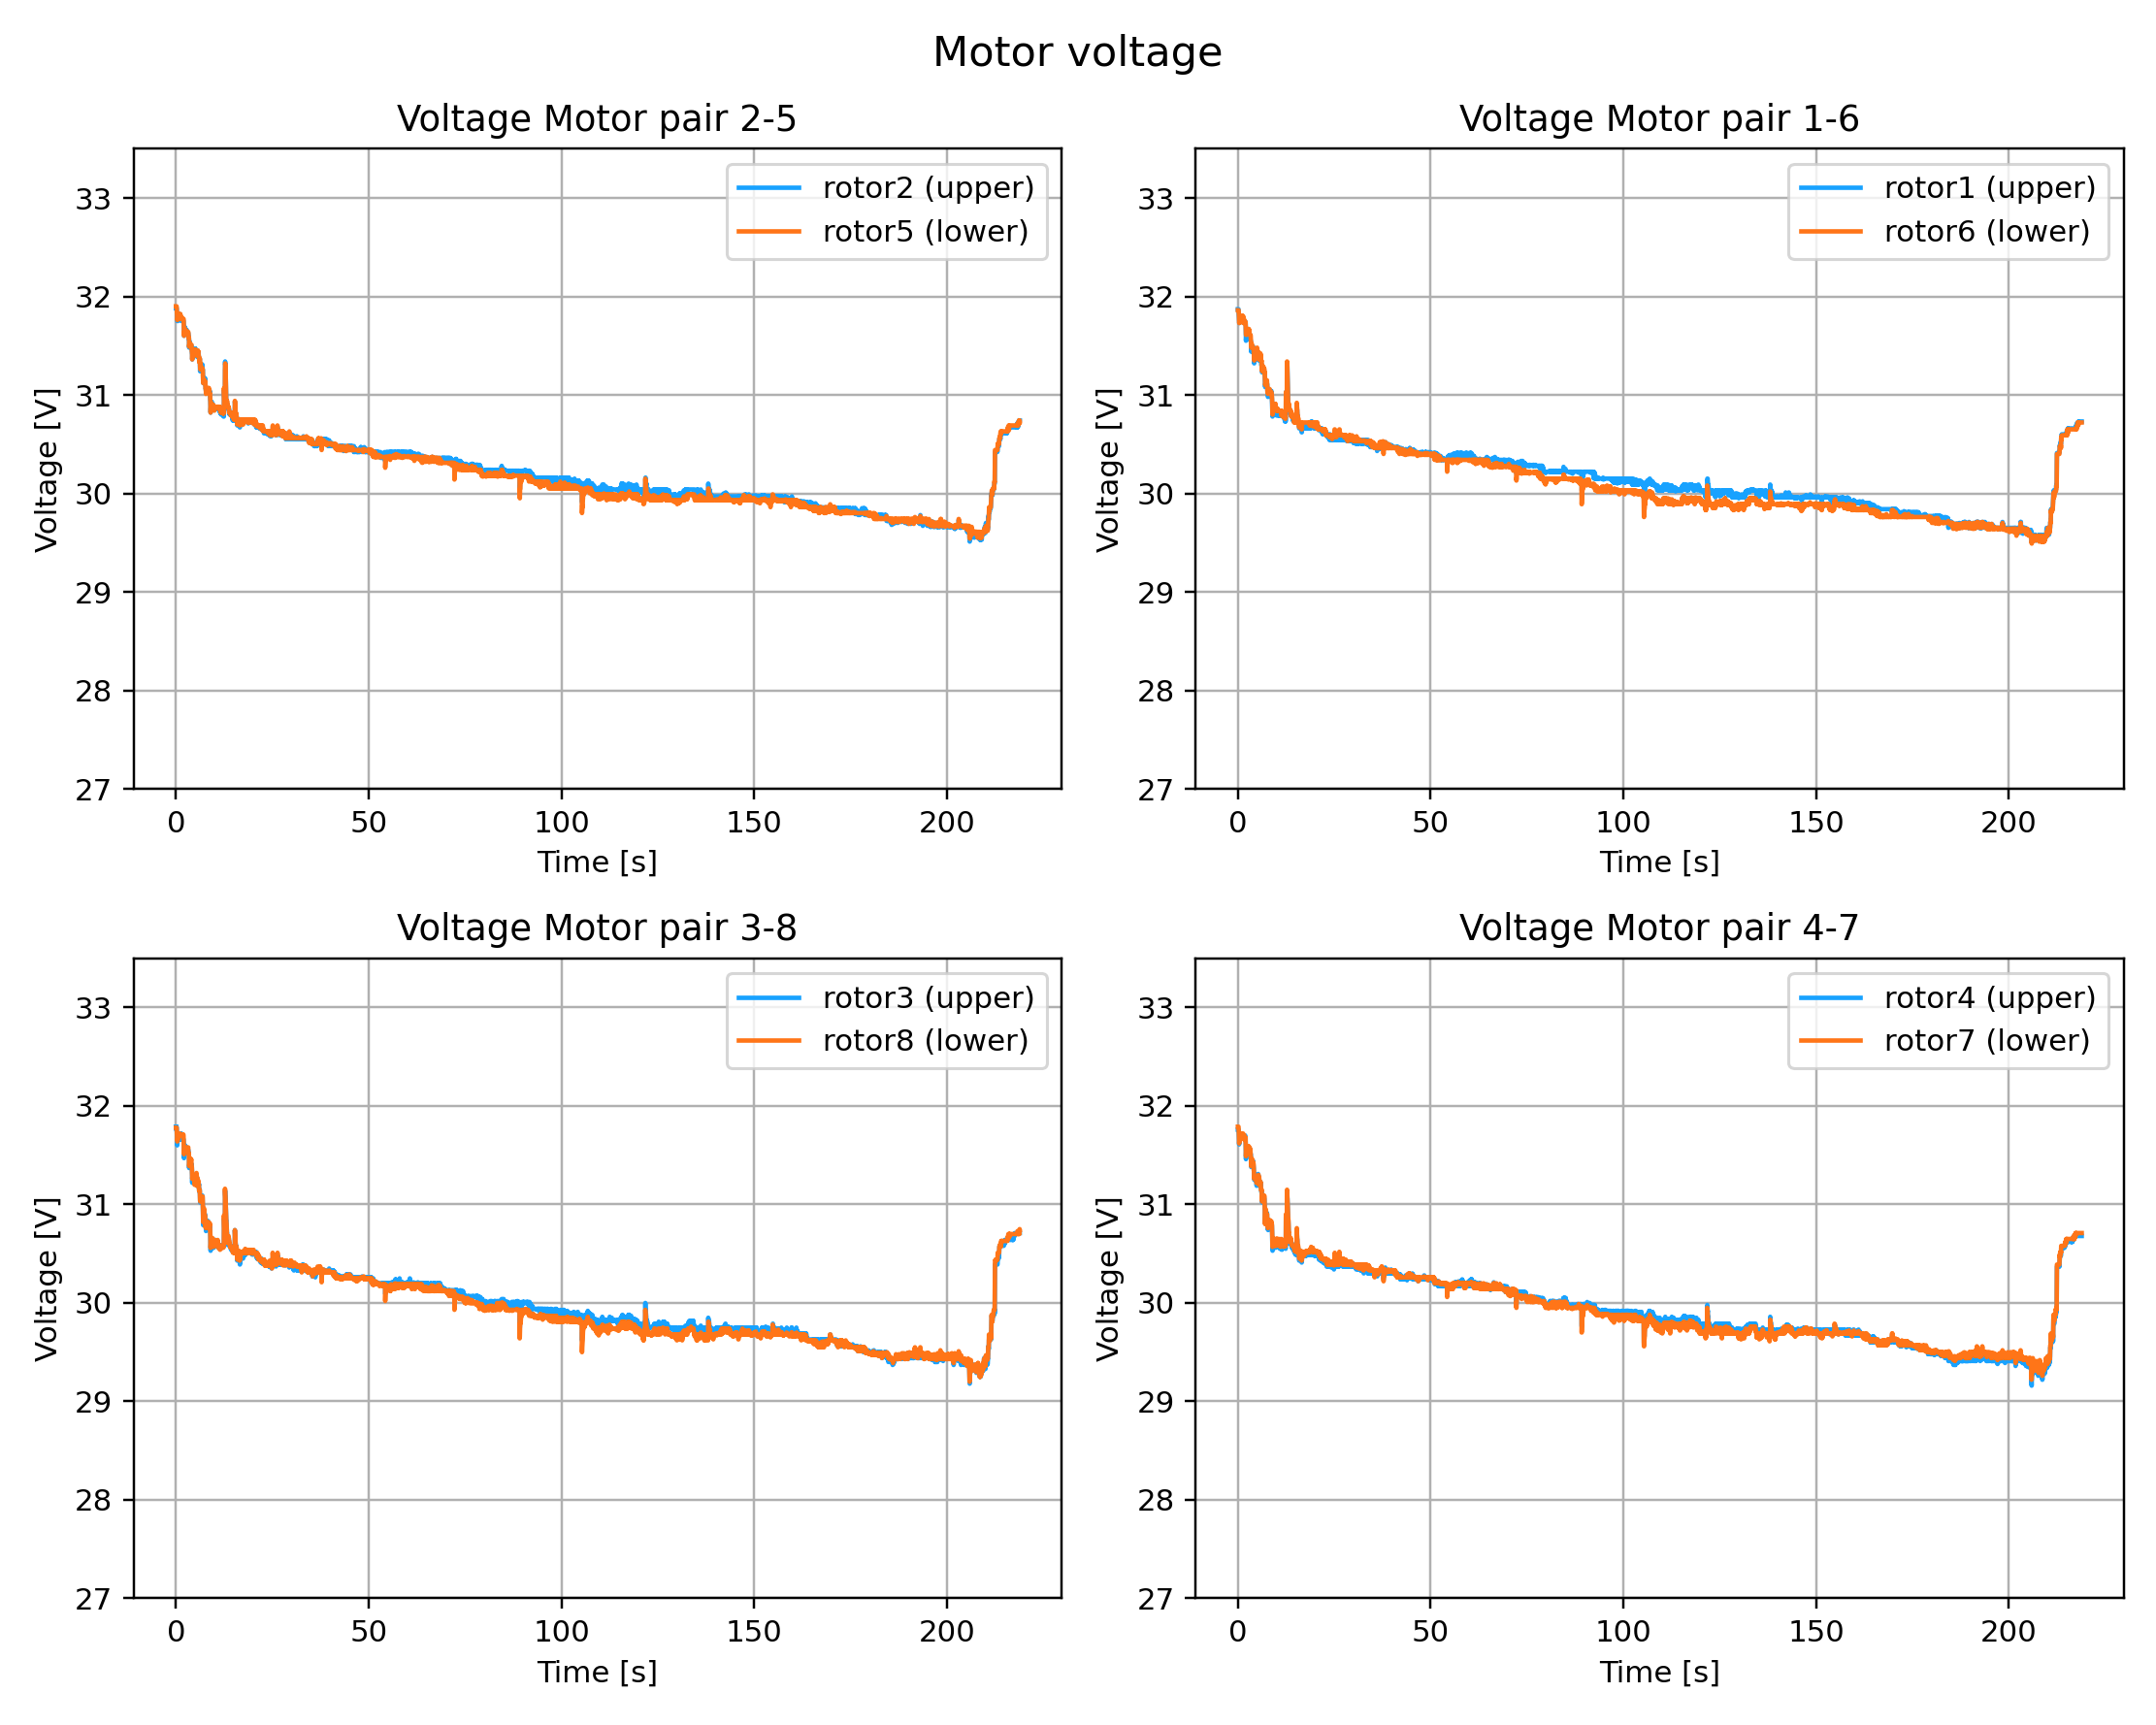

In [50]:
# current over time

fig6, ax6 = plt.subplots(2, 2, figsize=(10,8))
fig6.suptitle('Motor voltage', fontsize=14)
# Rotor pairs

ax6[0][0].plot(time,voltage[1], color=upCol, label='rotor2 (upper)')
ax6[0][0].plot(time,voltage[4], color=lowCol, label='rotor5 (lower)')

ax6[0][1].plot(time,voltage[0], color=upCol, label='rotor1 (upper)')
ax6[0][1].plot(time,voltage[5], color=lowCol, label='rotor6 (lower)')


ax6[1][0].plot(time,voltage[2], color=upCol, label='rotor3 (upper)')
ax6[1][0].plot(time,voltage[7], color=lowCol, label='rotor8 (lower)')

ax6[1][1].plot(time,voltage[3], color=upCol, label='rotor4 (upper)')
ax6[1][1].plot(time,voltage[6], color=lowCol, label='rotor7 (lower)')


for i in range(2):
    for j in range(2):
        ax6[i][j].set_xlabel('Time [s]')
        ax6[i][j].set_ylabel('Voltage [V]')
        ax6[i][j].set_ylim(27, 33.5)
        ax6[i][j].grid()
        ax6[i][j].legend()

ax6[0][0].set_title(f'Voltage Motor pair 2-5')
ax6[0][1].set_title(f'Voltage Motor pair 1-6')
ax6[1][0].set_title(f'Voltage Motor pair 3-8')
ax6[1][1].set_title(f'Voltage Motor pair 4-7')
fig6.tight_layout()

<IPython.core.display.Javascript object>


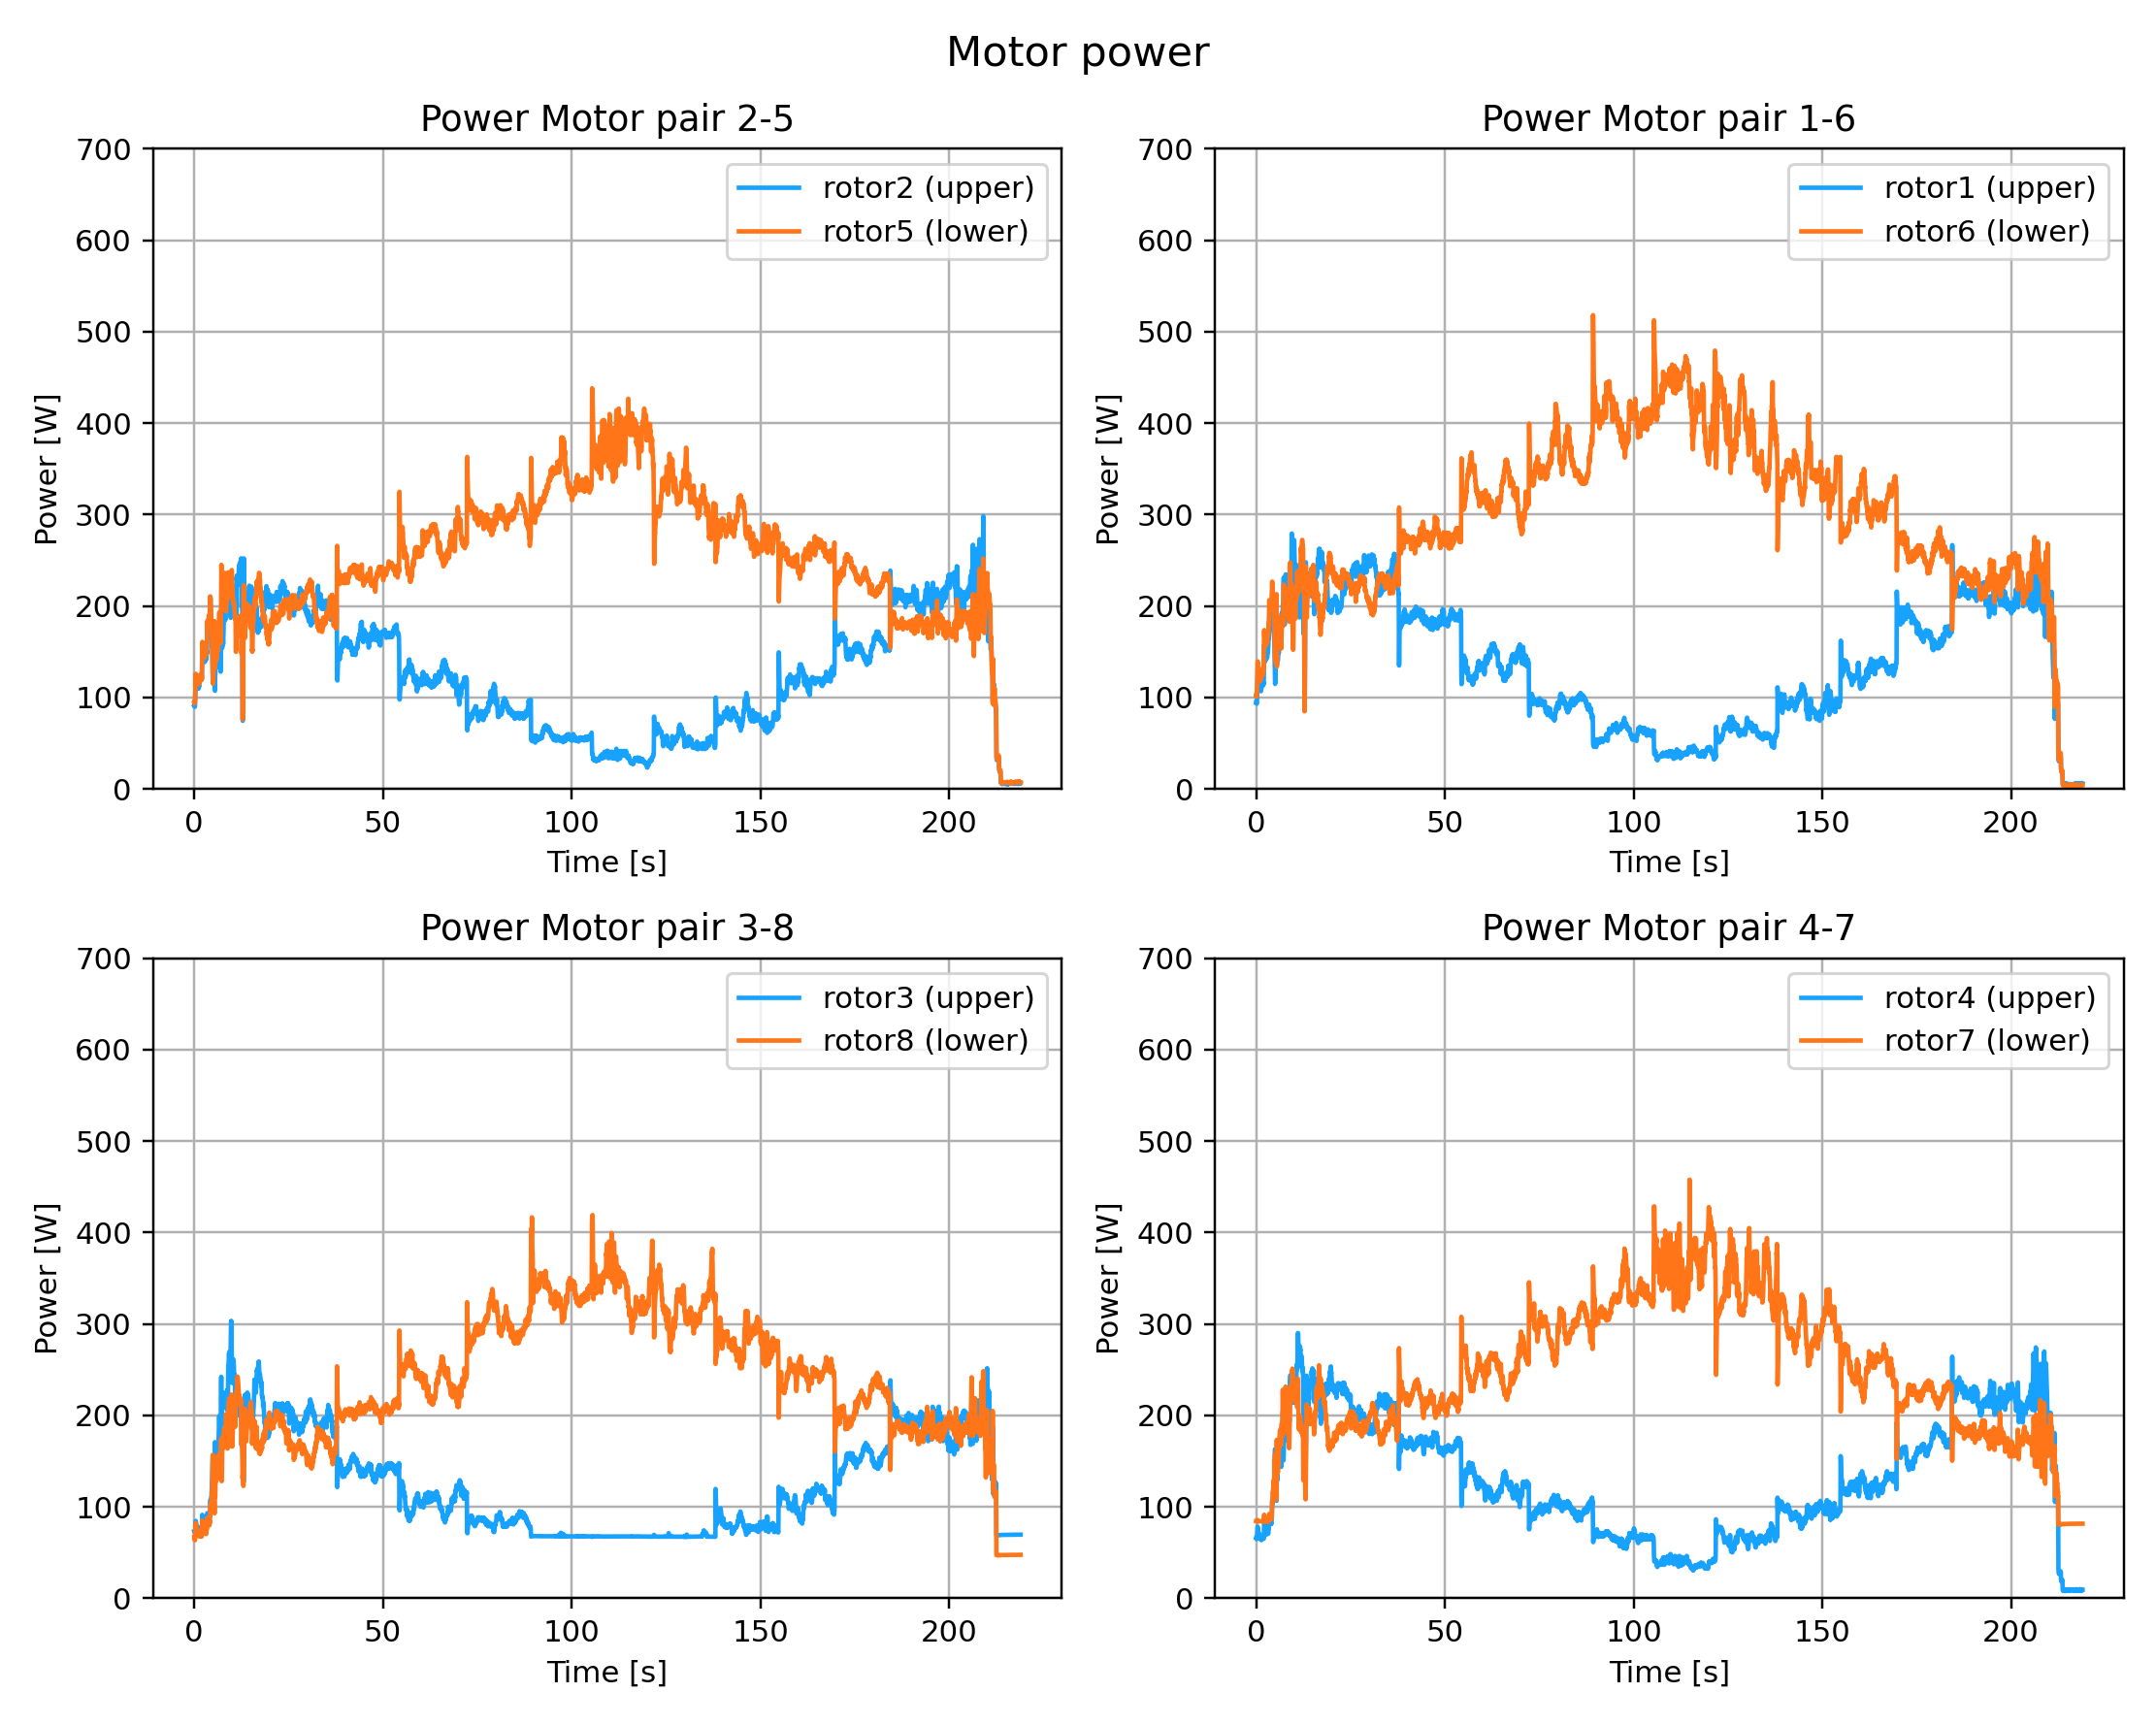

In [51]:
# Power over time for each motor

fig7, ax7 = plt.subplots(2, 2, figsize=(10,8))
fig7.suptitle('Motor power', fontsize=14)

# Rotor pairs

ax7[0][0].plot(time,power[1], color=upCol, label='rotor2 (upper)')
ax7[0][0].plot(time,power[4], color=lowCol, label='rotor5 (lower)')

ax7[0][1].plot(time,power[0], color=upCol, label='rotor1 (upper)')
ax7[0][1].plot(time,power[5], color=lowCol, label='rotor6 (lower)')


ax7[1][0].plot(time,power[2], color=upCol, label='rotor3 (upper)')
ax7[1][0].plot(time,power[7], color=lowCol, label='rotor8 (lower)')

ax7[1][1].plot(time,power[3], color=upCol, label='rotor4 (upper)')
ax7[1][1].plot(time,power[6], color=lowCol, label='rotor7 (lower)')


for i in range(2):
    for j in range(2):
        ax7[i][j].set_xlabel('Time [s]')
        ax7[i][j].set_ylabel('Power [W]')
        ax7[i][j].set_ylim(0,700)
        ax7[i][j].grid()
        ax7[i][j].legend()

ax7[0][0].set_title(f'Power Motor pair 2-5')
ax7[0][1].set_title(f'Power Motor pair 1-6')
ax7[1][0].set_title(f'Power Motor pair 3-8')
ax7[1][1].set_title(f'Power Motor pair 4-7')

fig7.tight_layout()

<IPython.core.display.Javascript object>


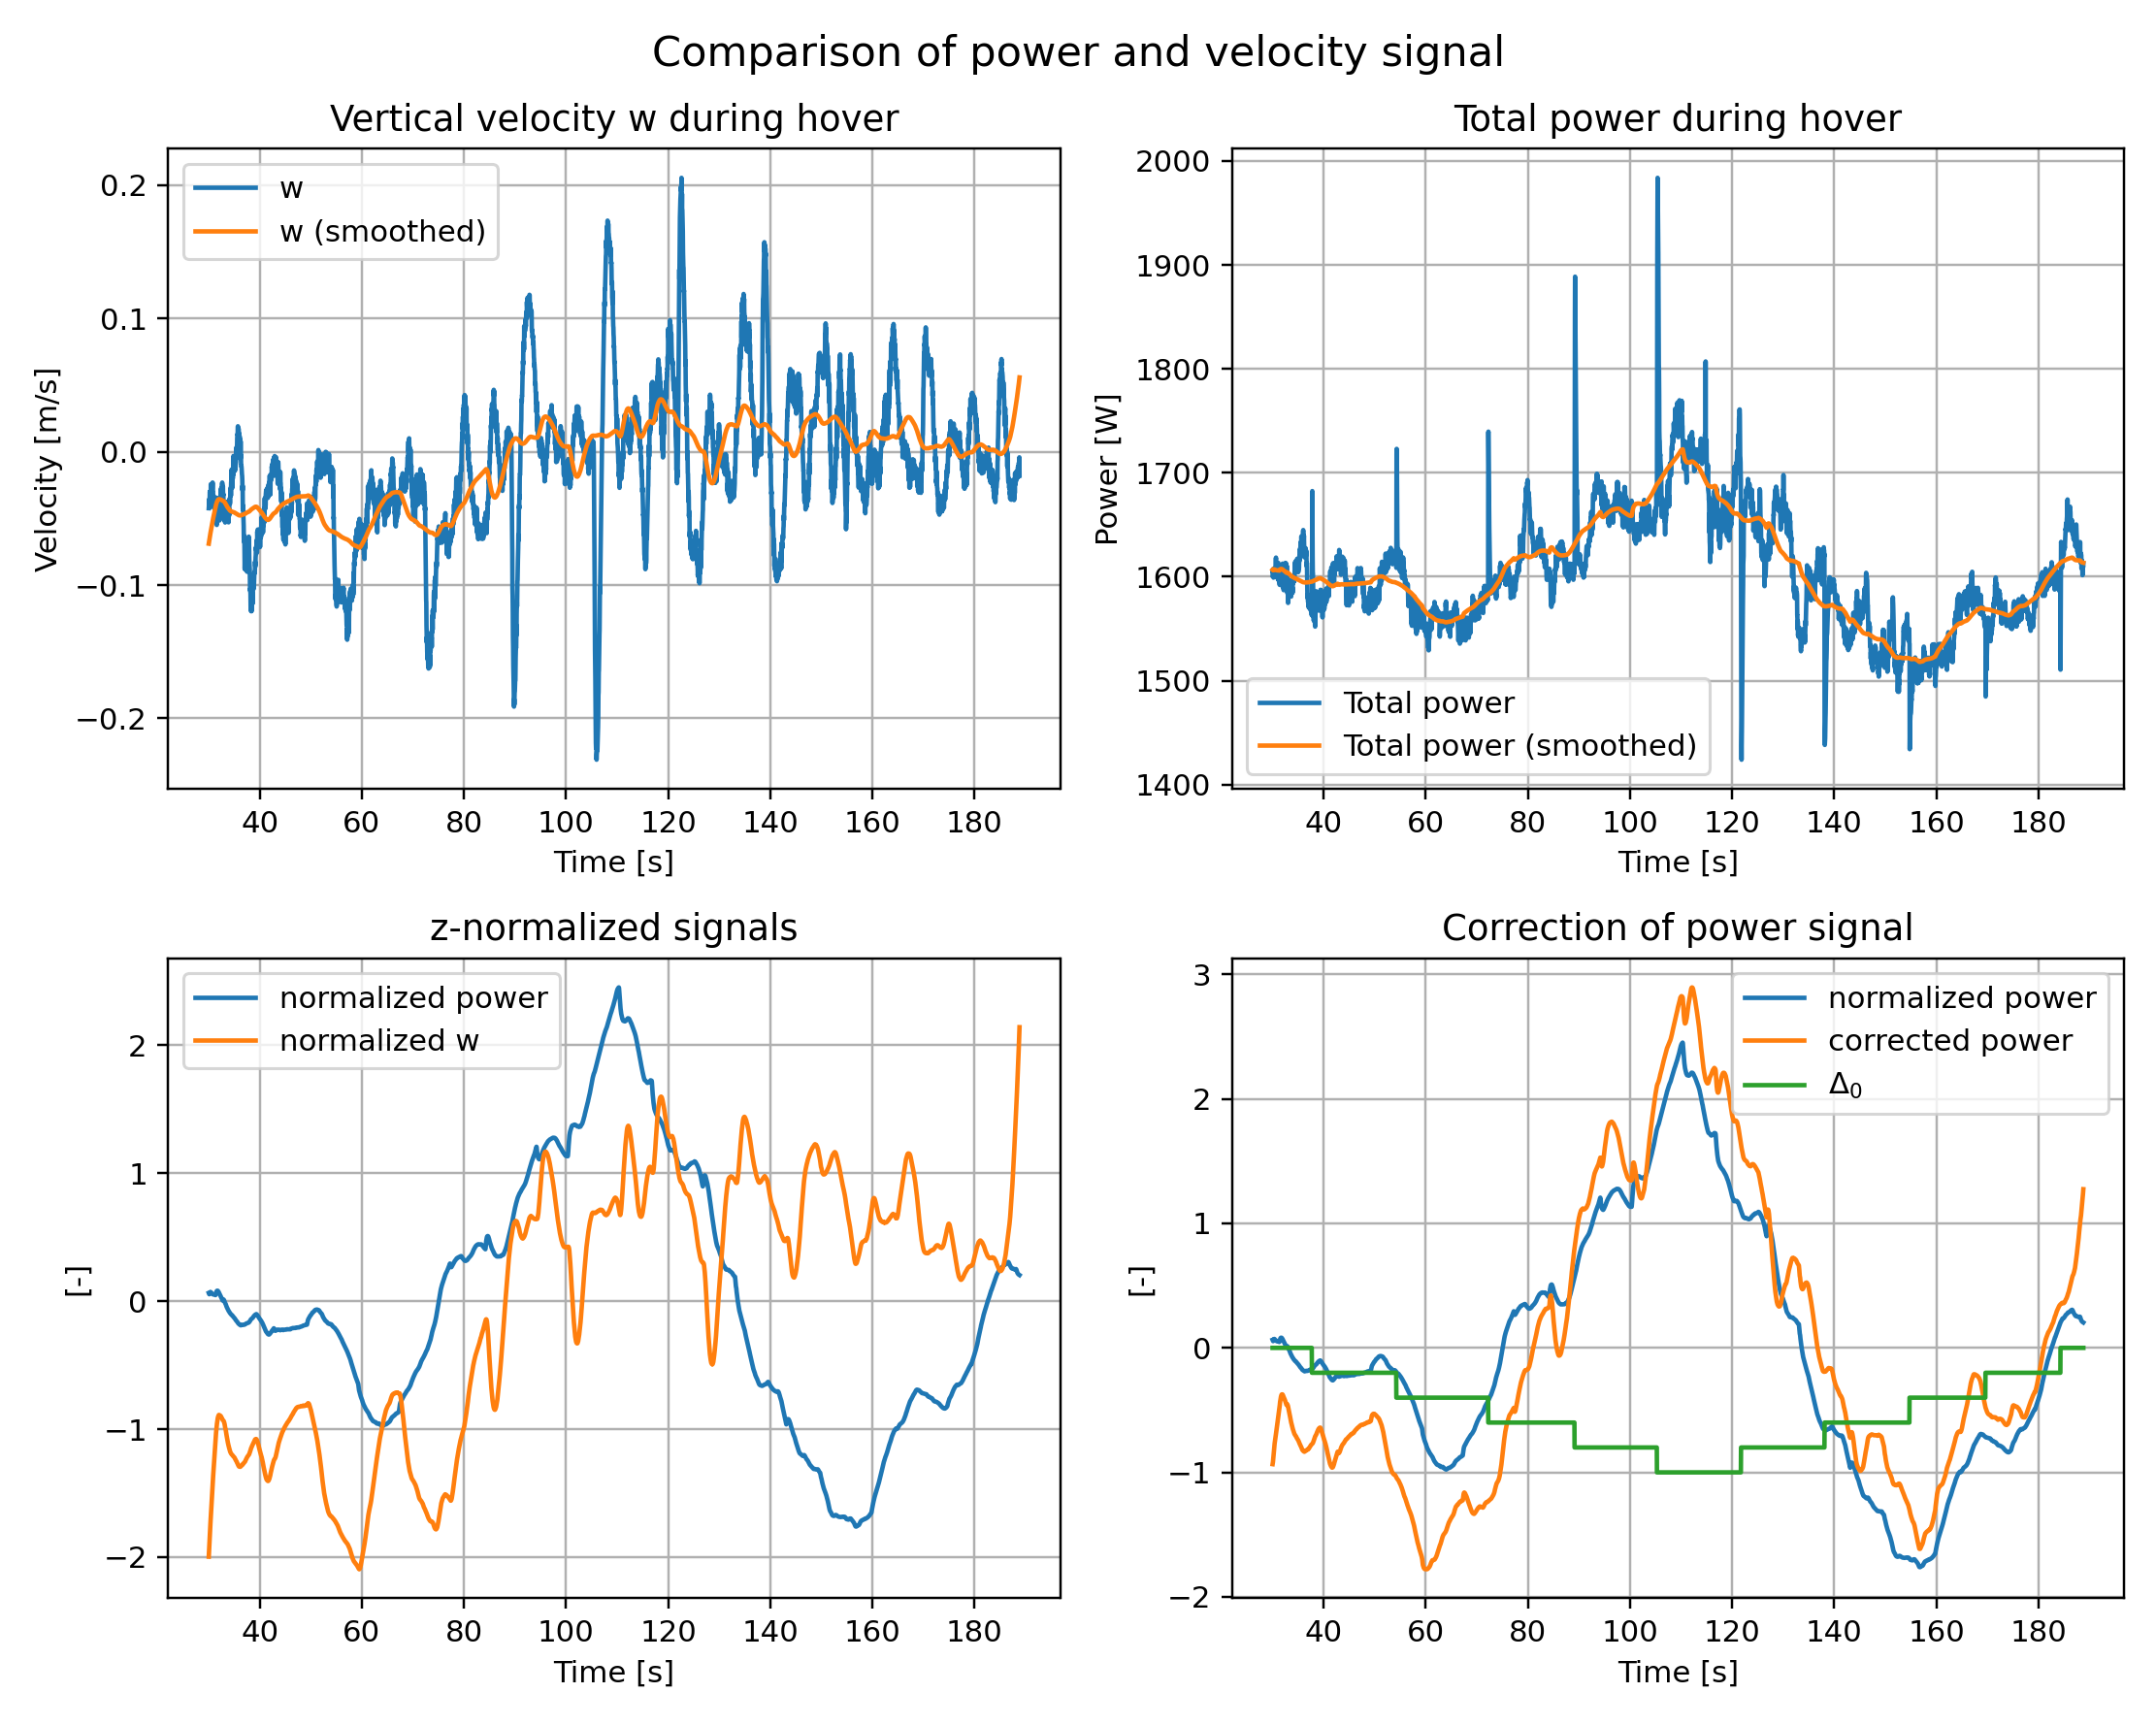

In [52]:
# Total power over time

fig8, ax8 = plt.subplots(2,2, figsize=(10,8))
fig8.suptitle('Comparison of power and velocity signal', fontsize=14)
# Rotor pairs

# vetical velocity plot (raw and smoothed with moving average filter)
ax8[0][0].set_title(f'Vertical velocity w during hover')
ax8[0][0].plot(time[hover], w[hover], label='w')
ax8[0][0].plot(time[hover], moving_average(w,300)[hover], label='w (smoothed)')

# total power (sum of all motors), raw and smoothed
ax8[0][1].set_title(f'Total power during hover')
ax8[0][1].plot(time[hover], total_power.values[hover], label='Total power')
ax8[0][1].plot(time[hover], moving_average(total_power.values,300)[hover], label='Total power (smoothed)')

# z-normalized signal of power and velocity
normalized_power = normalization(moving_average(total_power.values,300)[hover])
normalized_velocity = normalization(moving_average(w,300)[hover])

# plot normalized signals
ax8[1][0].set_title(f'z-normalized signals')
ax8[1][0].plot(time[hover], normalized_power, label='normalized power')
ax8[1][0].plot(time[hover], normalized_velocity, label='normalized w')

# Corrected signal
ax8[1][1].set_title(f'Correction of power signal')
ax8[1][1].plot(time[hover], normalized_power, label='normalized power')
ax8[1][1].plot(time[hover], normalized_power + normalized_velocity/2, label='corrected power')
ax8[1][1].plot(time[hover], delta0[hover], label='$\Delta_0$')


for i in range(2):
        ax8[0][i].set_xlabel('Time [s]')
        ax8[0][i].grid()
        ax8[0][i].legend()

for i in range(2):
    ax8[1][i].grid()
    ax8[1][i].set_xlabel('Time [s]')
    ax8[1][i].legend()

ax8[0][0].set_ylabel('Velocity [m/s]')
ax8[0][1].set_ylabel('Power [W]')
ax8[1][0].set_ylabel('[-]')
ax8[1][1].set_ylabel('[-]')

fig8.tight_layout()

<IPython.core.display.Javascript object>


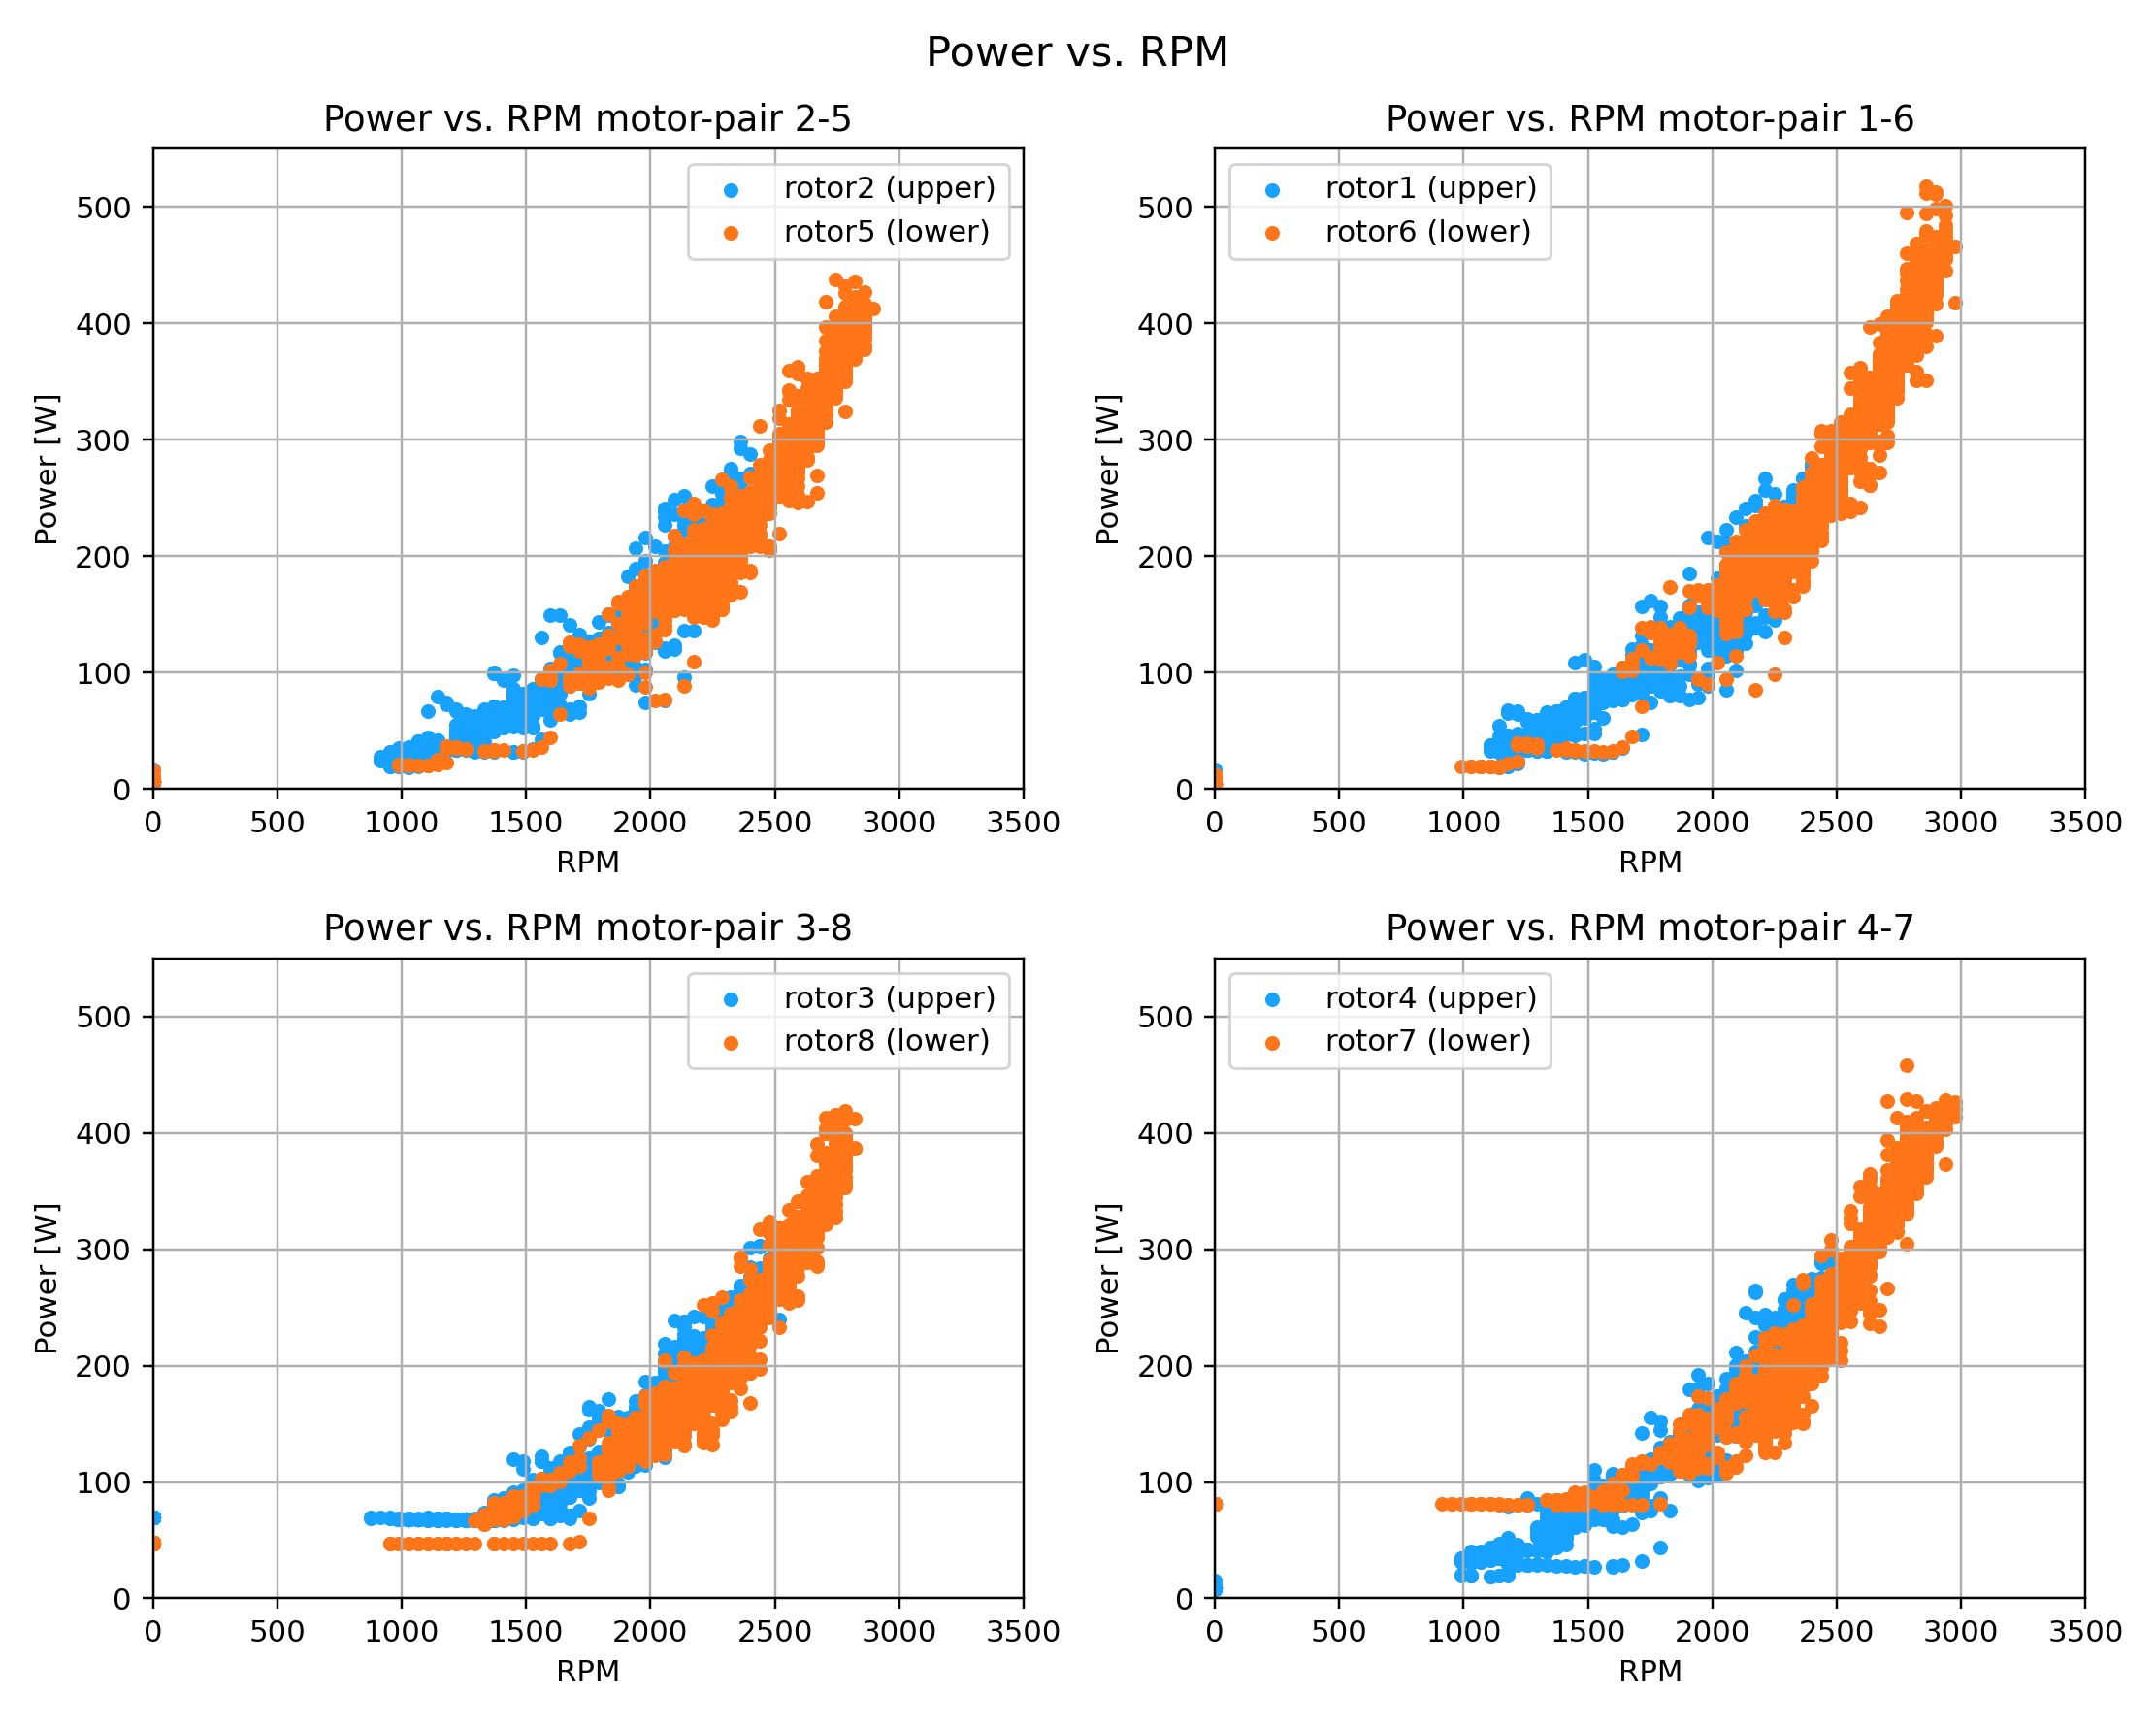

In [53]:
# Power over effective RPM

fig9, ax9 = plt.subplots(2, 2, figsize=(10,8))
fig9.suptitle('Power vs. RPM', fontsize=14)

# Rotor pairs

ax9[0][0].scatter(omega[1], power[1], s=markersize, color=upCol, label='rotor2 (upper)')
ax9[0][0].scatter(omega[4], power[4], s=markersize, color=lowCol, label='rotor5 (lower)')

ax9[0][1].scatter(omega[0], power[0], s=markersize, color=upCol, label='rotor1 (upper)')
ax9[0][1].scatter(omega[5], power[5], s=markersize, color=lowCol, label='rotor6 (lower)')

ax9[1][0].scatter(omega[2], power[2], s=markersize, color=upCol, label='rotor3 (upper)')
ax9[1][0].scatter(omega[7], power[7], s=markersize, color=lowCol, label='rotor8 (lower)')

ax9[1][1].scatter(omega[3], power[3], s=markersize, color=upCol, label='rotor4 (upper)')
ax9[1][1].scatter(omega[6], power[6], s=markersize, color=lowCol, label='rotor7 (lower)')


for i in range(2):
    for j in range(2):
        ax9[i][j].set_xlabel('RPM')
        ax9[i][j].set_ylabel('Power [W]')
        ax9[i][j].set_xlim(0,3500)
        ax9[i][j].set_ylim(0,550)
        ax9[i][j].grid()
        ax9[i][j].legend()

ax9[0][0].set_title(f'Power vs. RPM motor-pair 2-5')
ax9[0][1].set_title(f'Power vs. RPM motor-pair 1-6')
ax9[1][0].set_title(f'Power vs. RPM motor-pair 3-8')
ax9[1][1].set_title(f'Power vs. RPM motor-pair 4-7')
fig9.tight_layout()

<IPython.core.display.Javascript object>


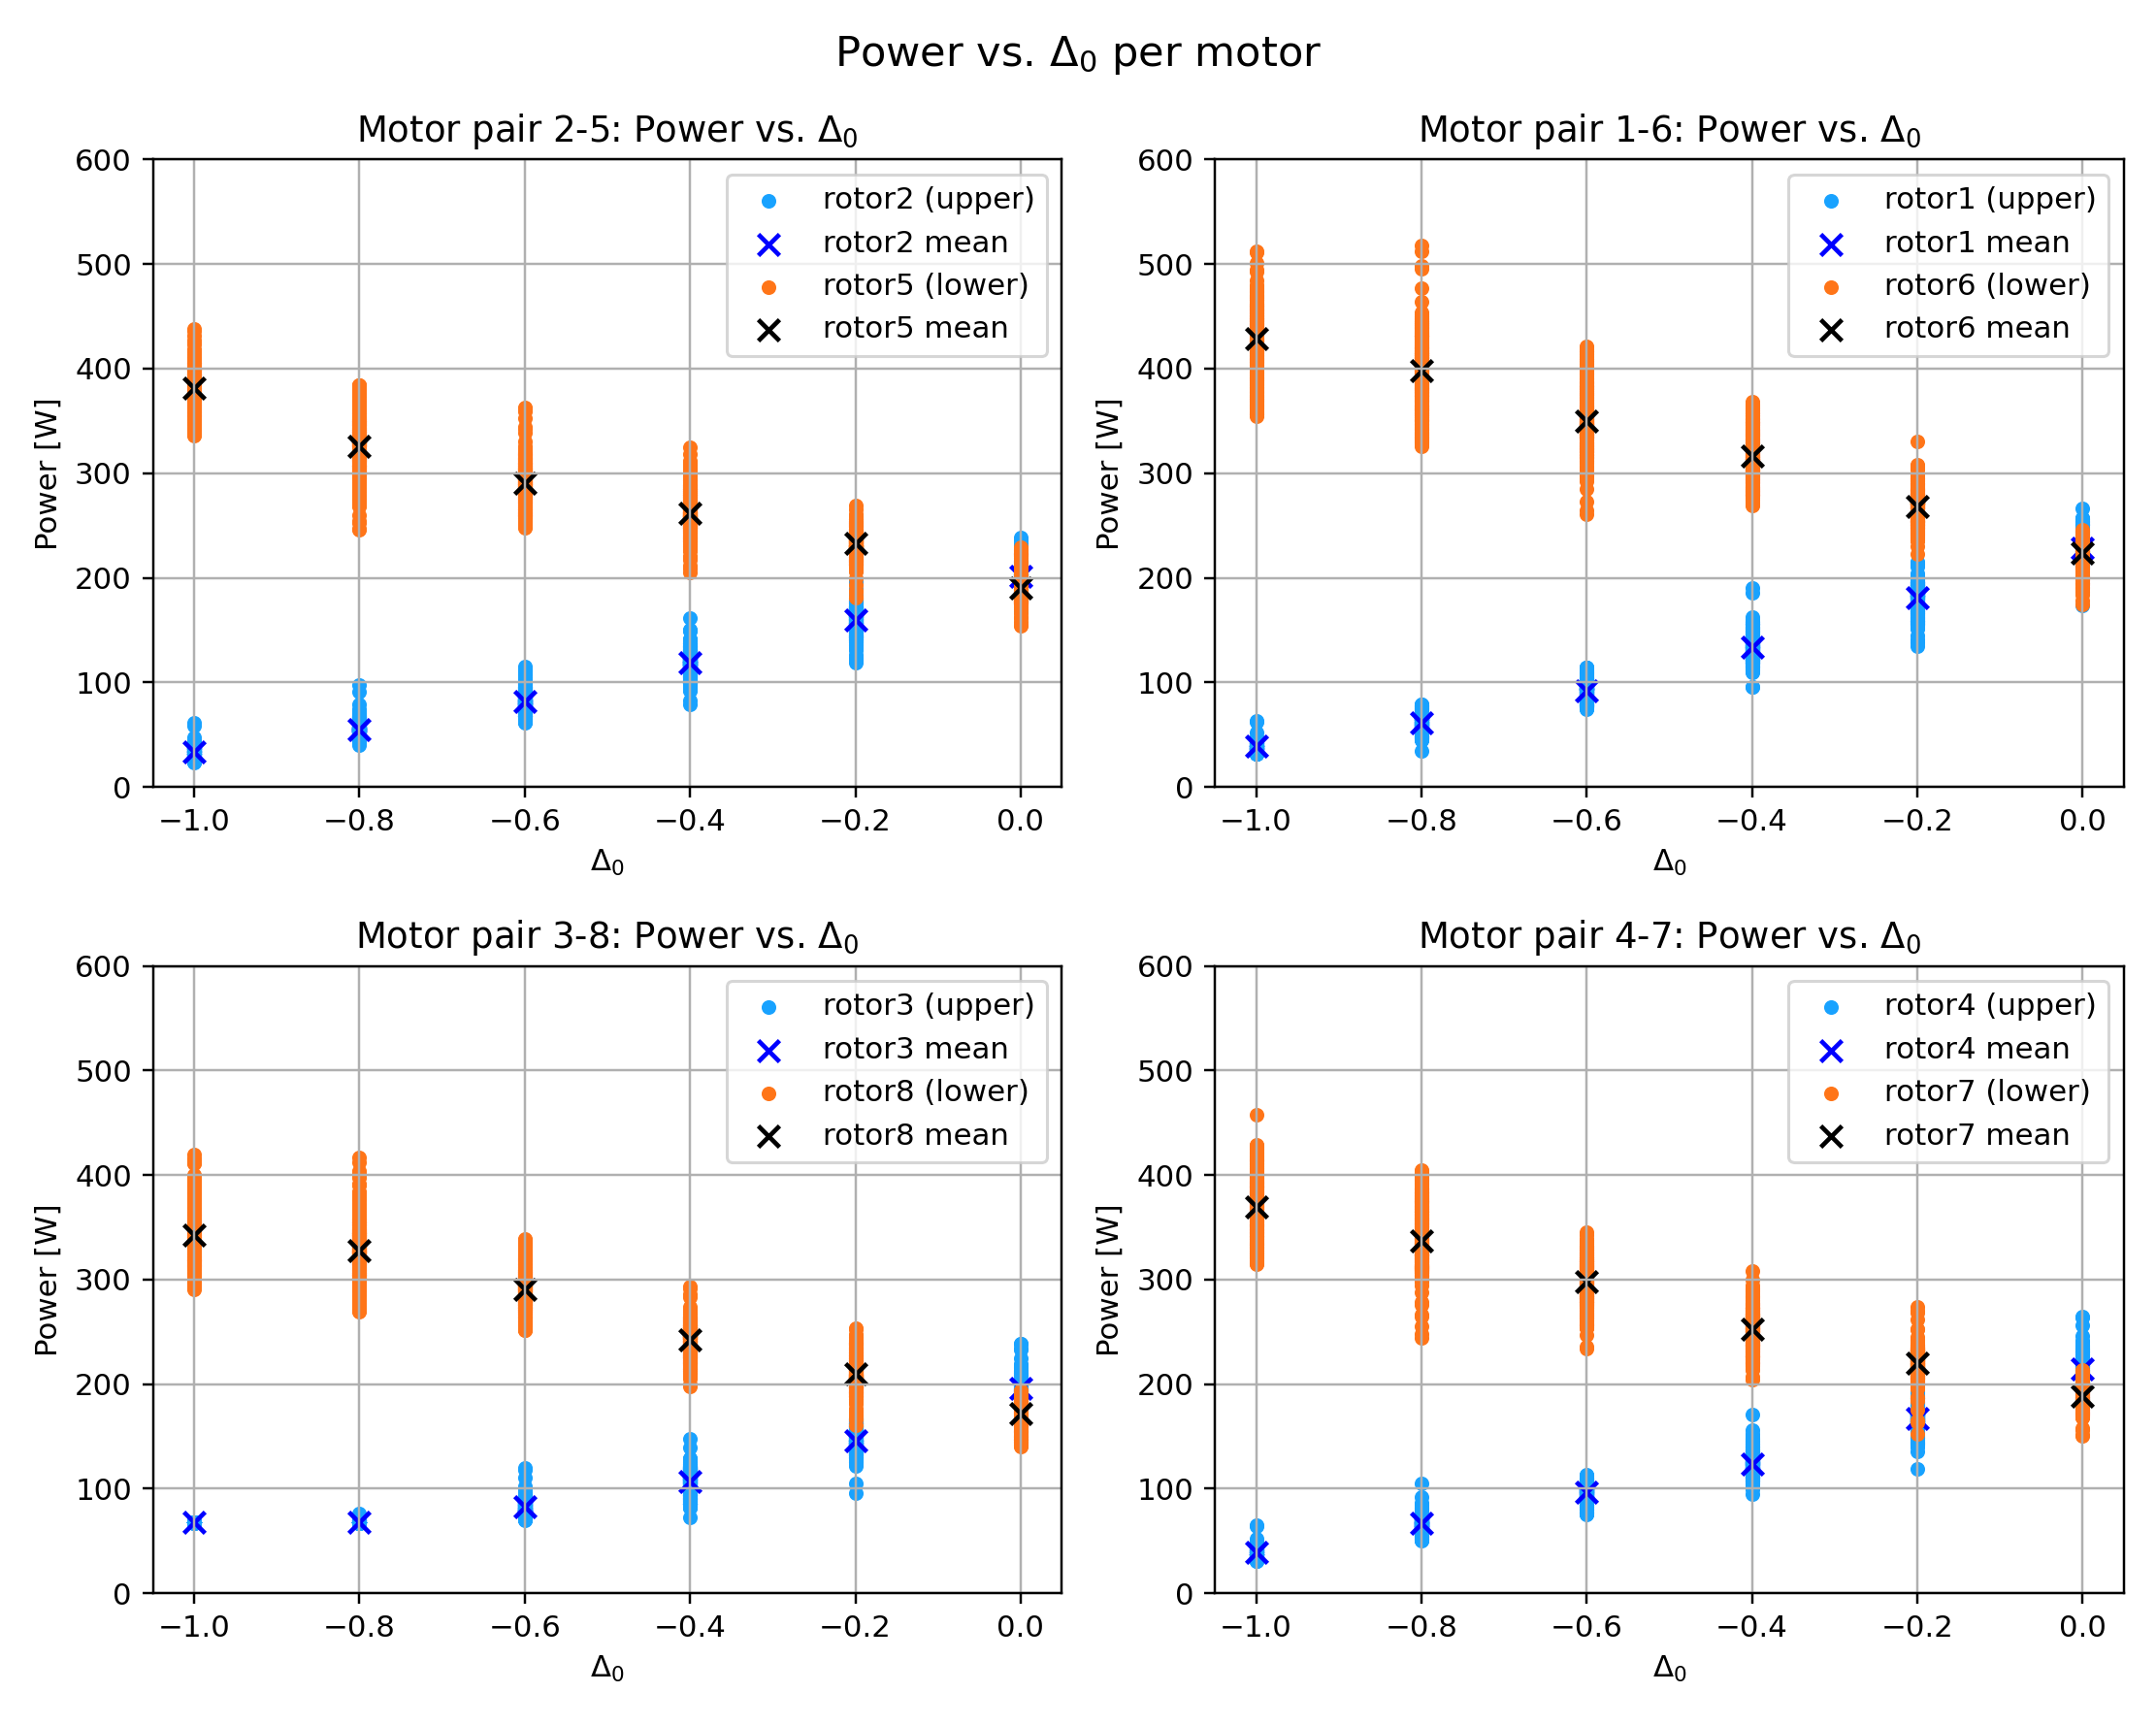

In [54]:
# Power per motor over delta0

fig10, ax10 = plt.subplots(2, 2, figsize=(10,8))
fig10.suptitle('Power vs. $\Delta_{0}$ per motor', fontsize=14)

# Rotor pairs
ax10[0][0].scatter(delta0[hover], power[1].values[hover], s=markersize, color= upCol, label='rotor2 (upper)')
ax10[0][0].scatter(delta0_values, meanPowerDelta0[1], marker='x', color=upMeanCol, s=50, label='rotor2 mean')

ax10[0][0].scatter(delta0[hover], power[4].values[hover], s=markersize, color= lowCol, label='rotor5 (lower)')
ax10[0][0].scatter(delta0_values, meanPowerDelta0[4], marker='x', color=lowMeanCol, s=50, label='rotor5 mean')

ax10[0][1].scatter(delta0[hover], power[0].values[hover], s=markersize, color= upCol, label='rotor1 (upper)')
ax10[0][1].scatter(delta0_values, meanPowerDelta0[0], marker='x', color=upMeanCol, s=50, label='rotor1 mean')

ax10[0][1].scatter(delta0[hover], power[5].values[hover], s=markersize, color= lowCol, label='rotor6 (lower)')
ax10[0][1].scatter(delta0_values, meanPowerDelta0[5], marker='x', color=lowMeanCol, s=50, label='rotor6 mean')

ax10[1][0].scatter(delta0[hover], power[2].values[hover], s=markersize, color= upCol, label='rotor3 (upper)')
ax10[1][0].scatter(delta0_values, meanPowerDelta0[2], marker='x', color=upMeanCol, s=50, label='rotor3 mean')

ax10[1][0].scatter(delta0[hover], power[7].values[hover], s=markersize, color= lowCol, label='rotor8 (lower)')
ax10[1][0].scatter(delta0_values, meanPowerDelta0[7], marker='x', color=lowMeanCol, s=50, label='rotor8 mean')

ax10[1][1].scatter(delta0[hover], power[3].values[hover], s=markersize, color= upCol, label='rotor4 (upper)')
ax10[1][1].scatter(delta0_values, meanPowerDelta0[3], marker='x', color=upMeanCol, s=50, label='rotor4 mean')

ax10[1][1].scatter(delta0[hover], power[6].values[hover], s=markersize, color= lowCol, label='rotor7 (lower)')
ax10[1][1].scatter(delta0_values, meanPowerDelta0[6], marker='x', color=lowMeanCol, s=50, label='rotor7 mean')

#
for i in range(2):
    for j in range(2):
        ax10[i][j].set_xlabel('$\Delta_{0}$')
        ax10[i][j].set_ylabel('Power [W]')
        ax10[i][j].set_ylim(0,600)
        ax10[i][j].grid()
        ax10[i][j].legend()

ax10[0][0].set_title(f'Motor pair 2-5: Power vs. $\Delta_0$')
ax10[0][1].set_title(f'Motor pair 1-6: Power vs. $\Delta_0$')
ax10[1][0].set_title(f'Motor pair 3-8: Power vs. $\Delta_0$')
ax10[1][1].set_title(f'Motor pair 4-7: Power vs. $\Delta_0$')
fig10.tight_layout()

<IPython.core.display.Javascript object>


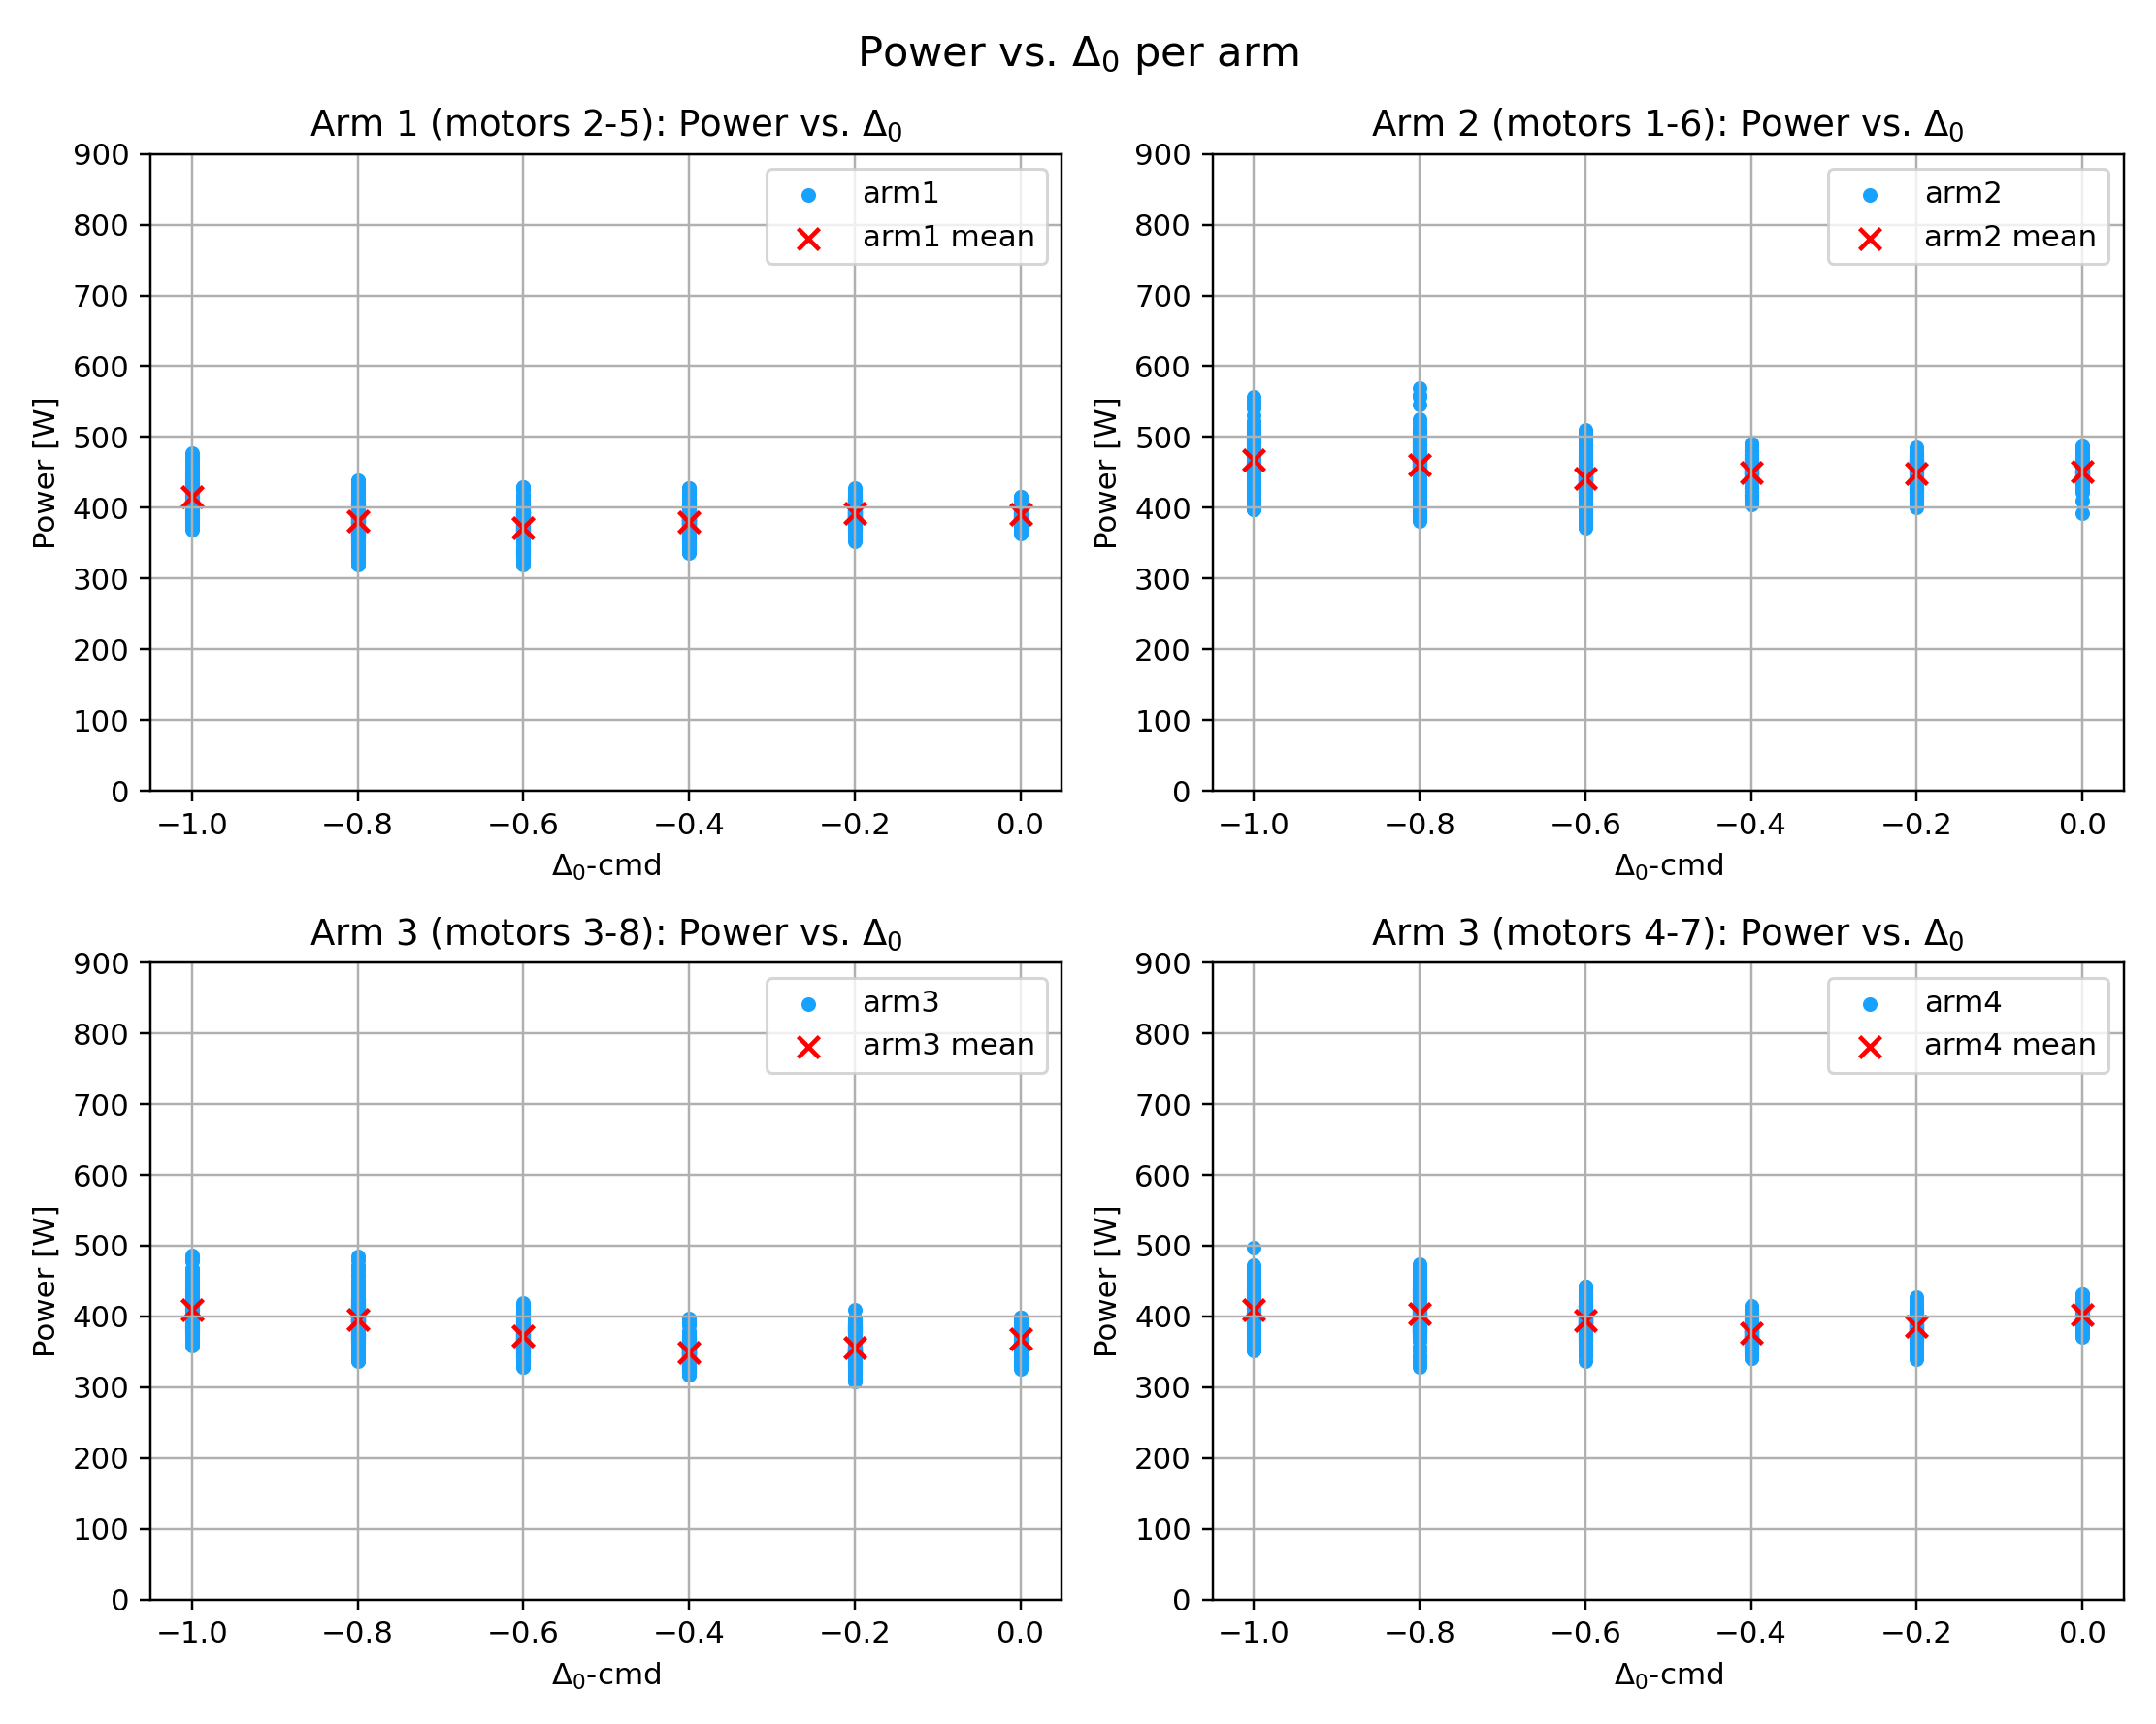

In [55]:
# Power per arm over delta0

fig11, ax11 = plt.subplots(2, 2, figsize=(10,8))
fig11.suptitle('Power vs. $\Delta_{0}$ per arm', fontsize=14)

# Arms
ax11[0][0].scatter(delta0[hover], power_pair['25'].values[hover], color=armCol, s=markersize, label='arm1')
ax11[0][1].scatter(delta0[hover], power_pair['16'].values[hover], color=armCol, s=markersize, label='arm2')
ax11[1][0].scatter(delta0[hover], power_pair['38'].values[hover], color=armCol, s=markersize, label='arm3')
ax11[1][1].scatter(delta0[hover], power_pair['47'].values[hover], color=armCol, s=markersize, label='arm4')

# Rotor pairs
markersize=50
ax11[0][0].scatter(delta0_values, meanPowerArm[0], marker='x', color=armMeanCol, s=markersize, label='arm1 mean')
ax11[0][1].scatter(delta0_values, meanPowerArm[1], marker='x', color=armMeanCol, s=markersize, label='arm2 mean')
ax11[1][0].scatter(delta0_values, meanPowerArm[2], marker='x', color=armMeanCol, s=markersize, label='arm3 mean')
ax11[1][1].scatter(delta0_values, meanPowerArm[3], marker='x', color=armMeanCol, s=markersize, label='arm4 mean')

markersize=15

for i in range(2):
    for j in range(2):
        ax11[i][j].set_xlabel('$\Delta_{0}$-cmd')
        ax11[i][j].set_ylabel('Power [W]')
        ax11[i][j].set_ylim(0, 900)
        ax11[i][j].grid()
        ax11[i][j].legend()

ax11[0][0].set_title(f'Arm 1 (motors 2-5): Power vs. $\Delta_0$')
ax11[0][1].set_title(f'Arm 2 (motors 1-6): Power vs. $\Delta_0$')
ax11[1][0].set_title(f'Arm 3 (motors 3-8): Power vs. $\Delta_0$')
ax11[1][1].set_title(f'Arm 3 (motors 4-7): Power vs. $\Delta_0$')
fig11.tight_layout()

<IPython.core.display.Javascript object>


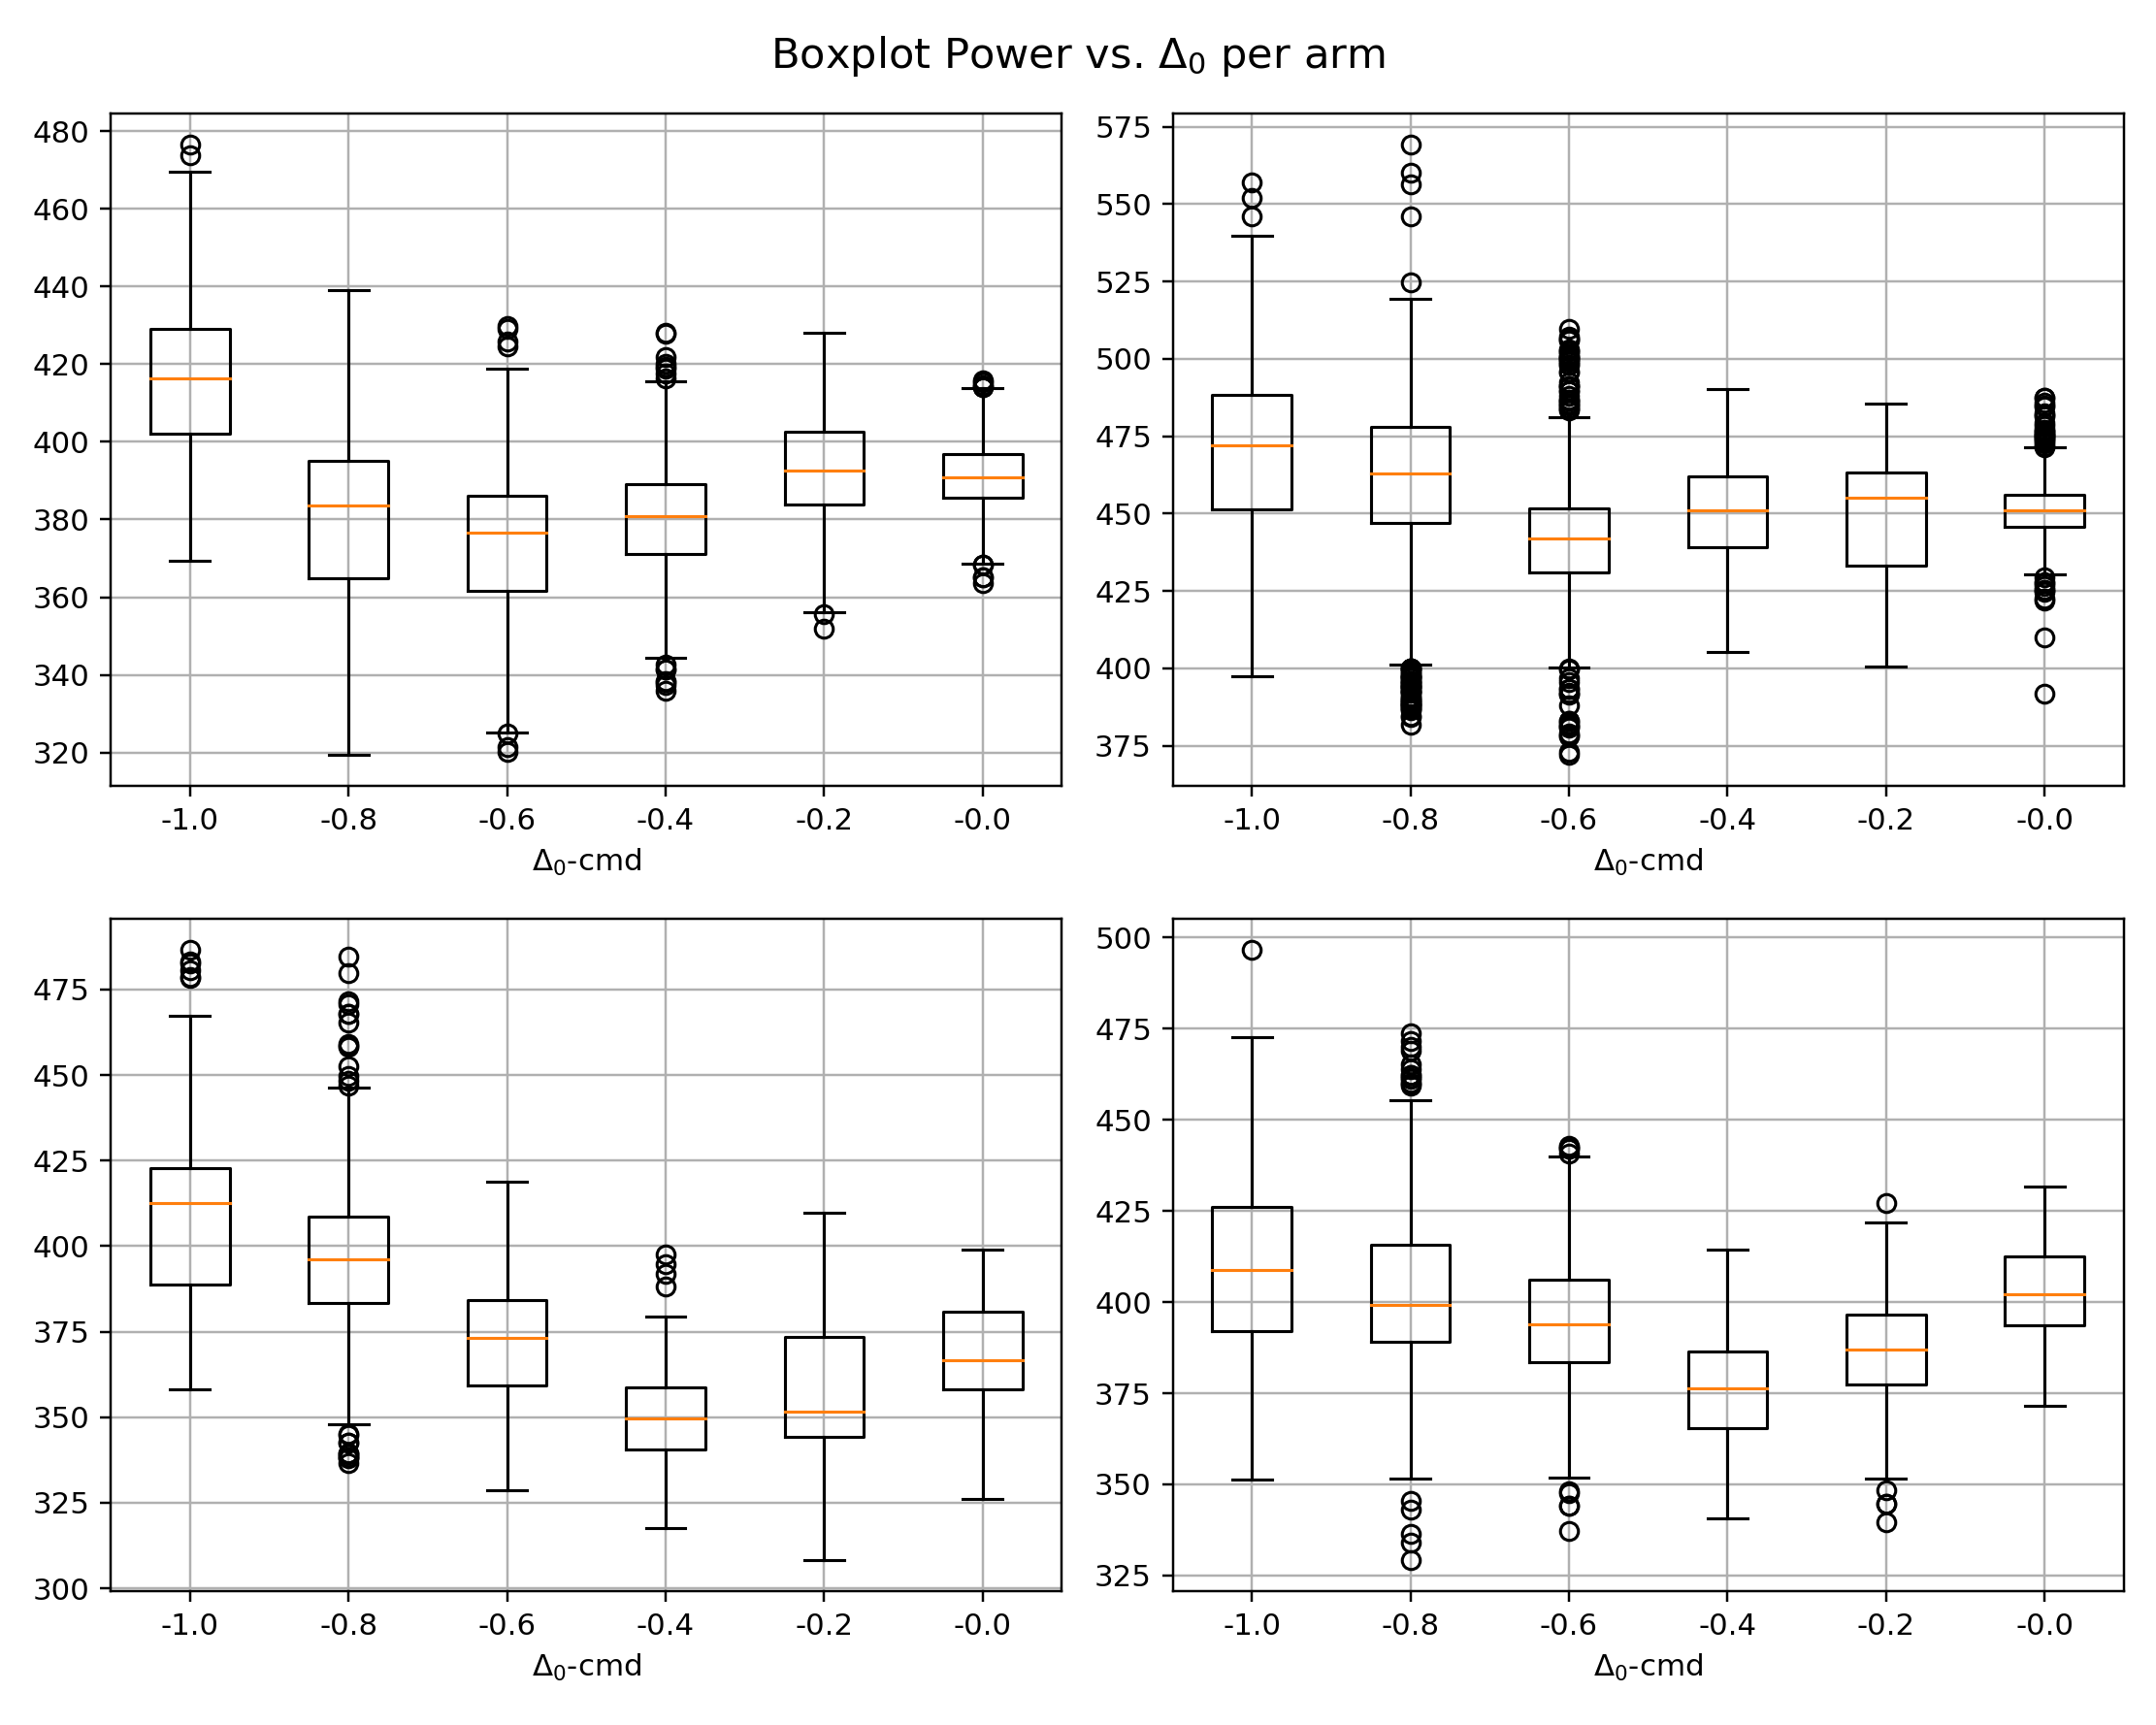

In [56]:
# Power per arm over delta0

fig14, ax14 = plt.subplots(2, 2, figsize=(10,8))
fig14.suptitle('Boxplot Power vs. $\Delta_{0}$ per arm', fontsize=14)

# Arms
ax14[0][0].boxplot(boxArm1)
ax14[0][1].boxplot(boxArm2)
ax14[1][0].boxplot(boxArm3)
ax14[1][1].boxplot(boxArm4)

for i in range(2):
    for j in range(2):
        ax14[i][j].set_xlabel('$\Delta_{0}$-cmd')
        ax14[i][j].set_xticklabels(boxLabels)
        ax14[i][j].grid()

fig14.tight_layout()

<IPython.core.display.Javascript object>


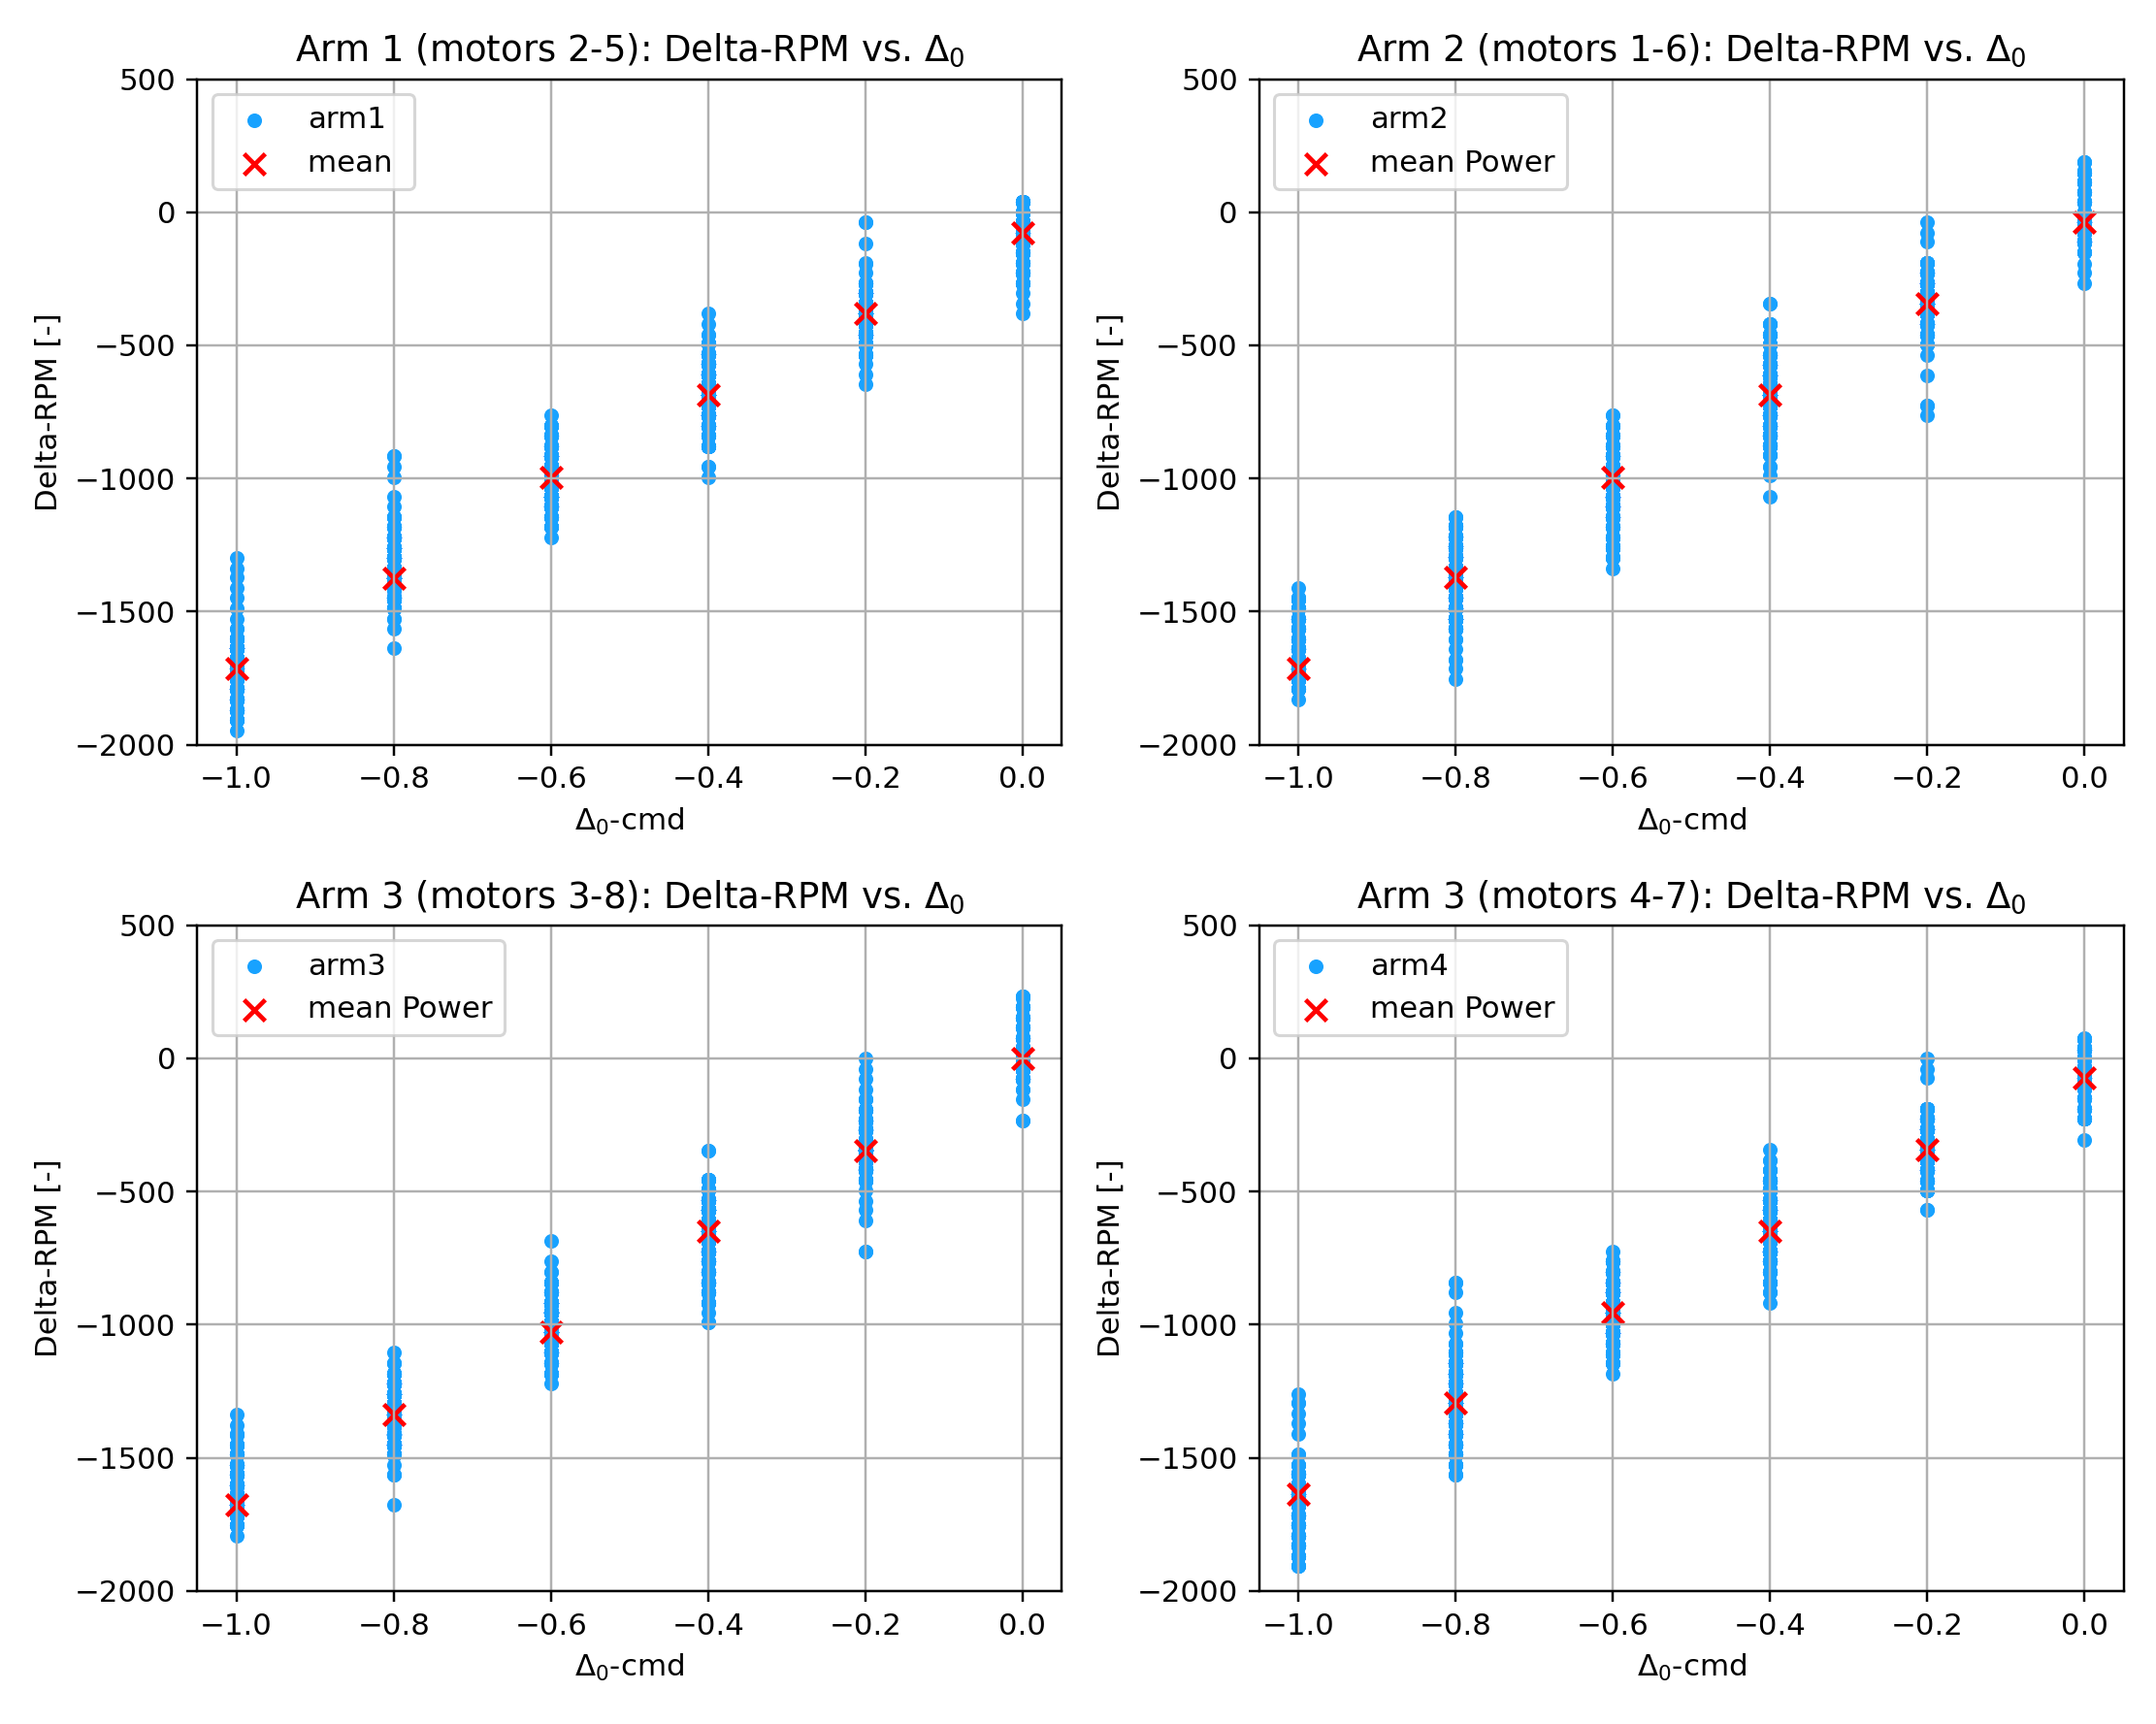

In [57]:
# Power per arm over deltaRPM

fig12, ax12 = plt.subplots(2, 2, figsize=(10,8))

# Arms
ax12[0][0].scatter(delta0[hover], deltaRPM['25'].values[hover], color=armCol, s=markersize, label='arm1')
ax12[0][1].scatter(delta0[hover], deltaRPM['16'].values[hover], color=armCol, s=markersize, label='arm2')
ax12[1][0].scatter(delta0[hover], deltaRPM['38'].values[hover], color=armCol, s=markersize, label='arm3')
ax12[1][1].scatter(delta0[hover], deltaRPM['47'].values[hover], color=armCol, s=markersize, label='arm4')

# Rotor pairs
markersize=50
ax12[0][0].scatter(delta0_values, deltaRpmArm[0], marker='x', color=armMeanCol, s=markersize, label='mean ')
ax12[0][1].scatter(delta0_values, deltaRpmArm[1], marker='x', color=armMeanCol, s=markersize, label='mean Power')
ax12[1][0].scatter(delta0_values, deltaRpmArm[2], marker='x', color=armMeanCol, s=markersize, label='mean Power')
ax12[1][1].scatter(delta0_values, deltaRpmArm[3], marker='x', color=armMeanCol, s=markersize, label='mean Power')

markersize=15

for i in range(2):
    for j in range(2):
        ax12[i][j].set_xlabel('$\Delta_{0}$-cmd')
        ax12[i][j].set_ylabel('Delta-RPM [-]')
        ax12[i][j].set_ylim(-2000, 500)
        ax12[i][j].grid()
        ax12[i][j].legend(loc='upper left')

ax12[0][0].set_title(f'Arm 1 (motors 2-5): Delta-RPM vs. $\Delta_0$')
ax12[0][1].set_title(f'Arm 2 (motors 1-6): Delta-RPM vs. $\Delta_0$')
ax12[1][0].set_title(f'Arm 3 (motors 3-8): Delta-RPM vs. $\Delta_0$')
ax12[1][1].set_title(f'Arm 3 (motors 4-7): Delta-RPM vs. $\Delta_0$')
fig12.tight_layout()

<IPython.core.display.Javascript object>


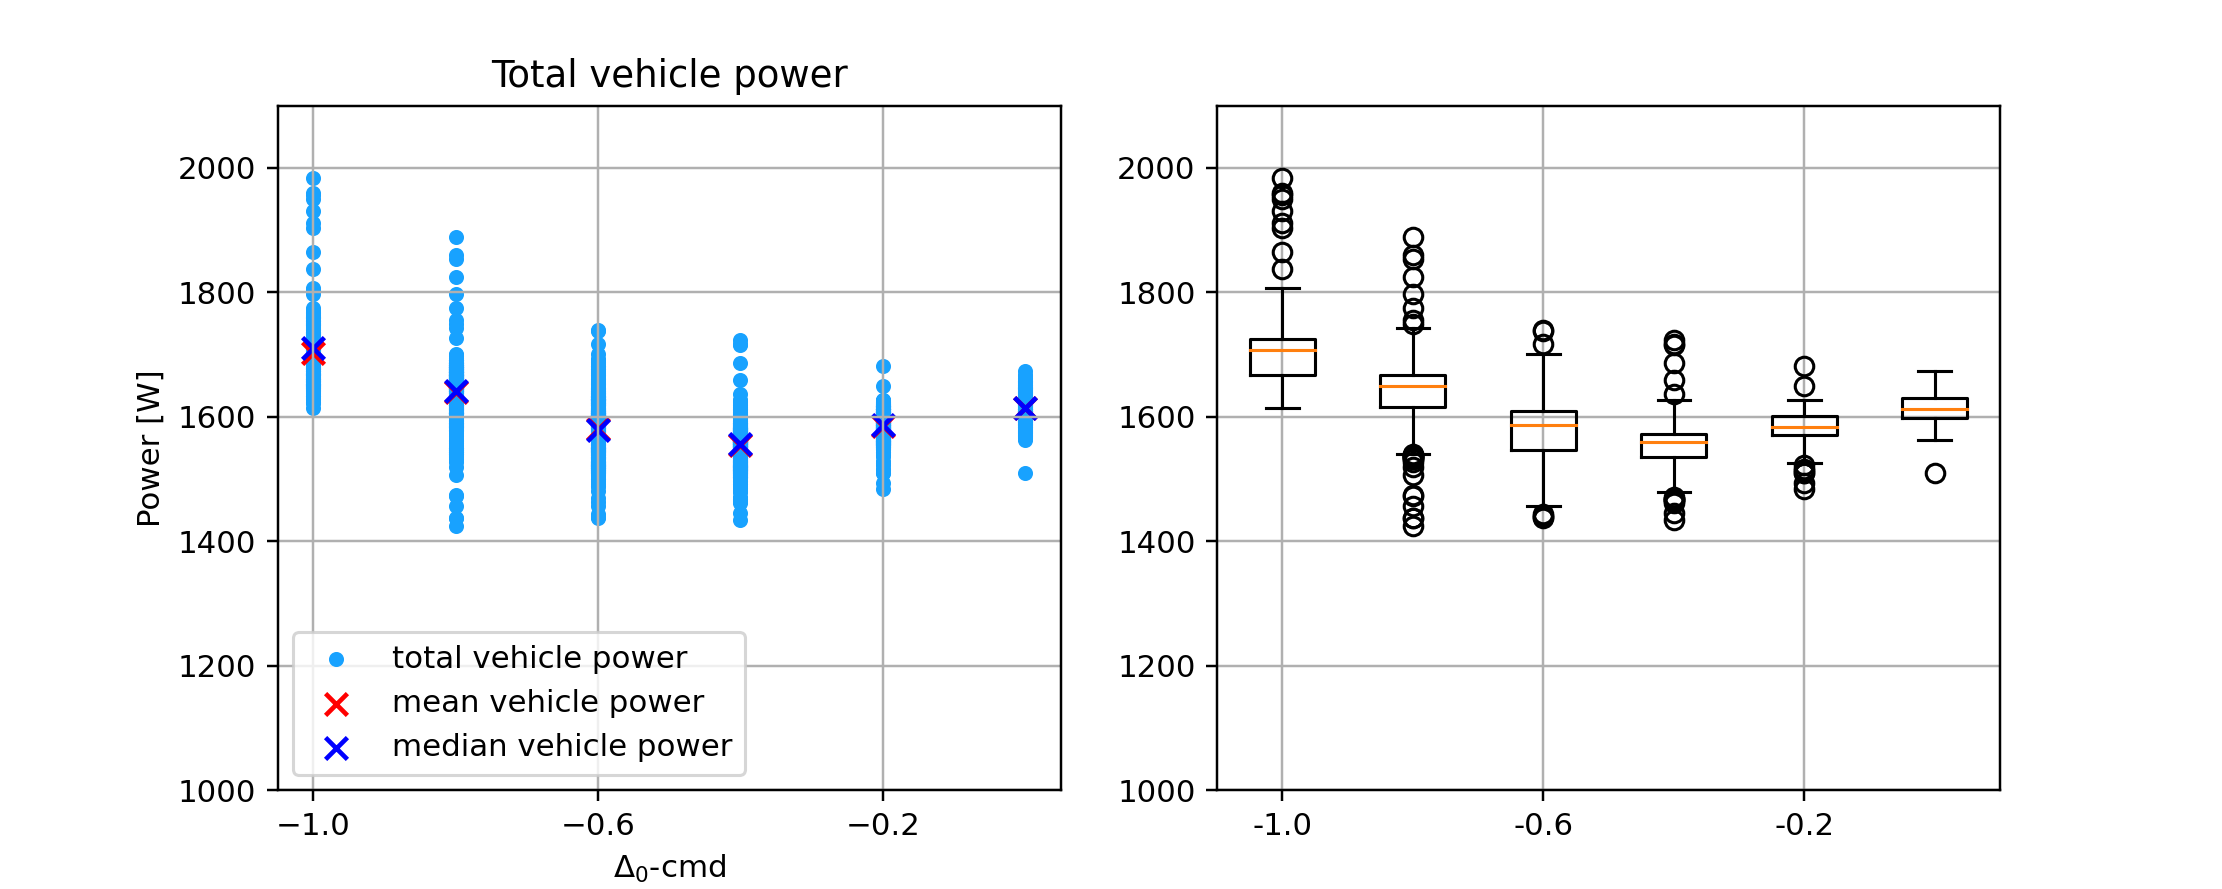

In [58]:
fig13, ax13 = plt.subplots(1,2,figsize=(10,4))

ax13[0].scatter(delta0[hover], total_power.values[hover], color=armCol, s=markersize, label='total vehicle power')
ax13[0].scatter(delta0_values, vehiclePower, marker='x', s=50, color=armMeanCol, label='mean vehicle power')
ax13[0].scatter(delta0_values, medianVehiclePower, marker='x', s=50, color='b', label='median vehicle power')

ax13[1].boxplot(boxTotal)

xticks = ax13[1].get_xticks()

ax13[1].set_xticks(xticks[::2])
ax13[1].set_xticklabels(boxLabels[::2])
ax13[1].set_ylim(1000, 2100)

ax13[0].set_xticks(np.unique(delta0)[::2])

ax13[0].set_xlabel('$\Delta_{0}$-cmd')
ax13[0].set_ylabel('Power [W]')
ax13[0].set_ylim(1000, 2100)
ax13[0].grid()
ax13[0].legend(loc='lower left')
ax13[0].set_title('Total vehicle power')    

#ax13[1].set_xlabel('$\Delta_{0}$-cmd')

ax13[1].grid()

fig11.tight_layout()

<IPython.core.display.Javascript object>


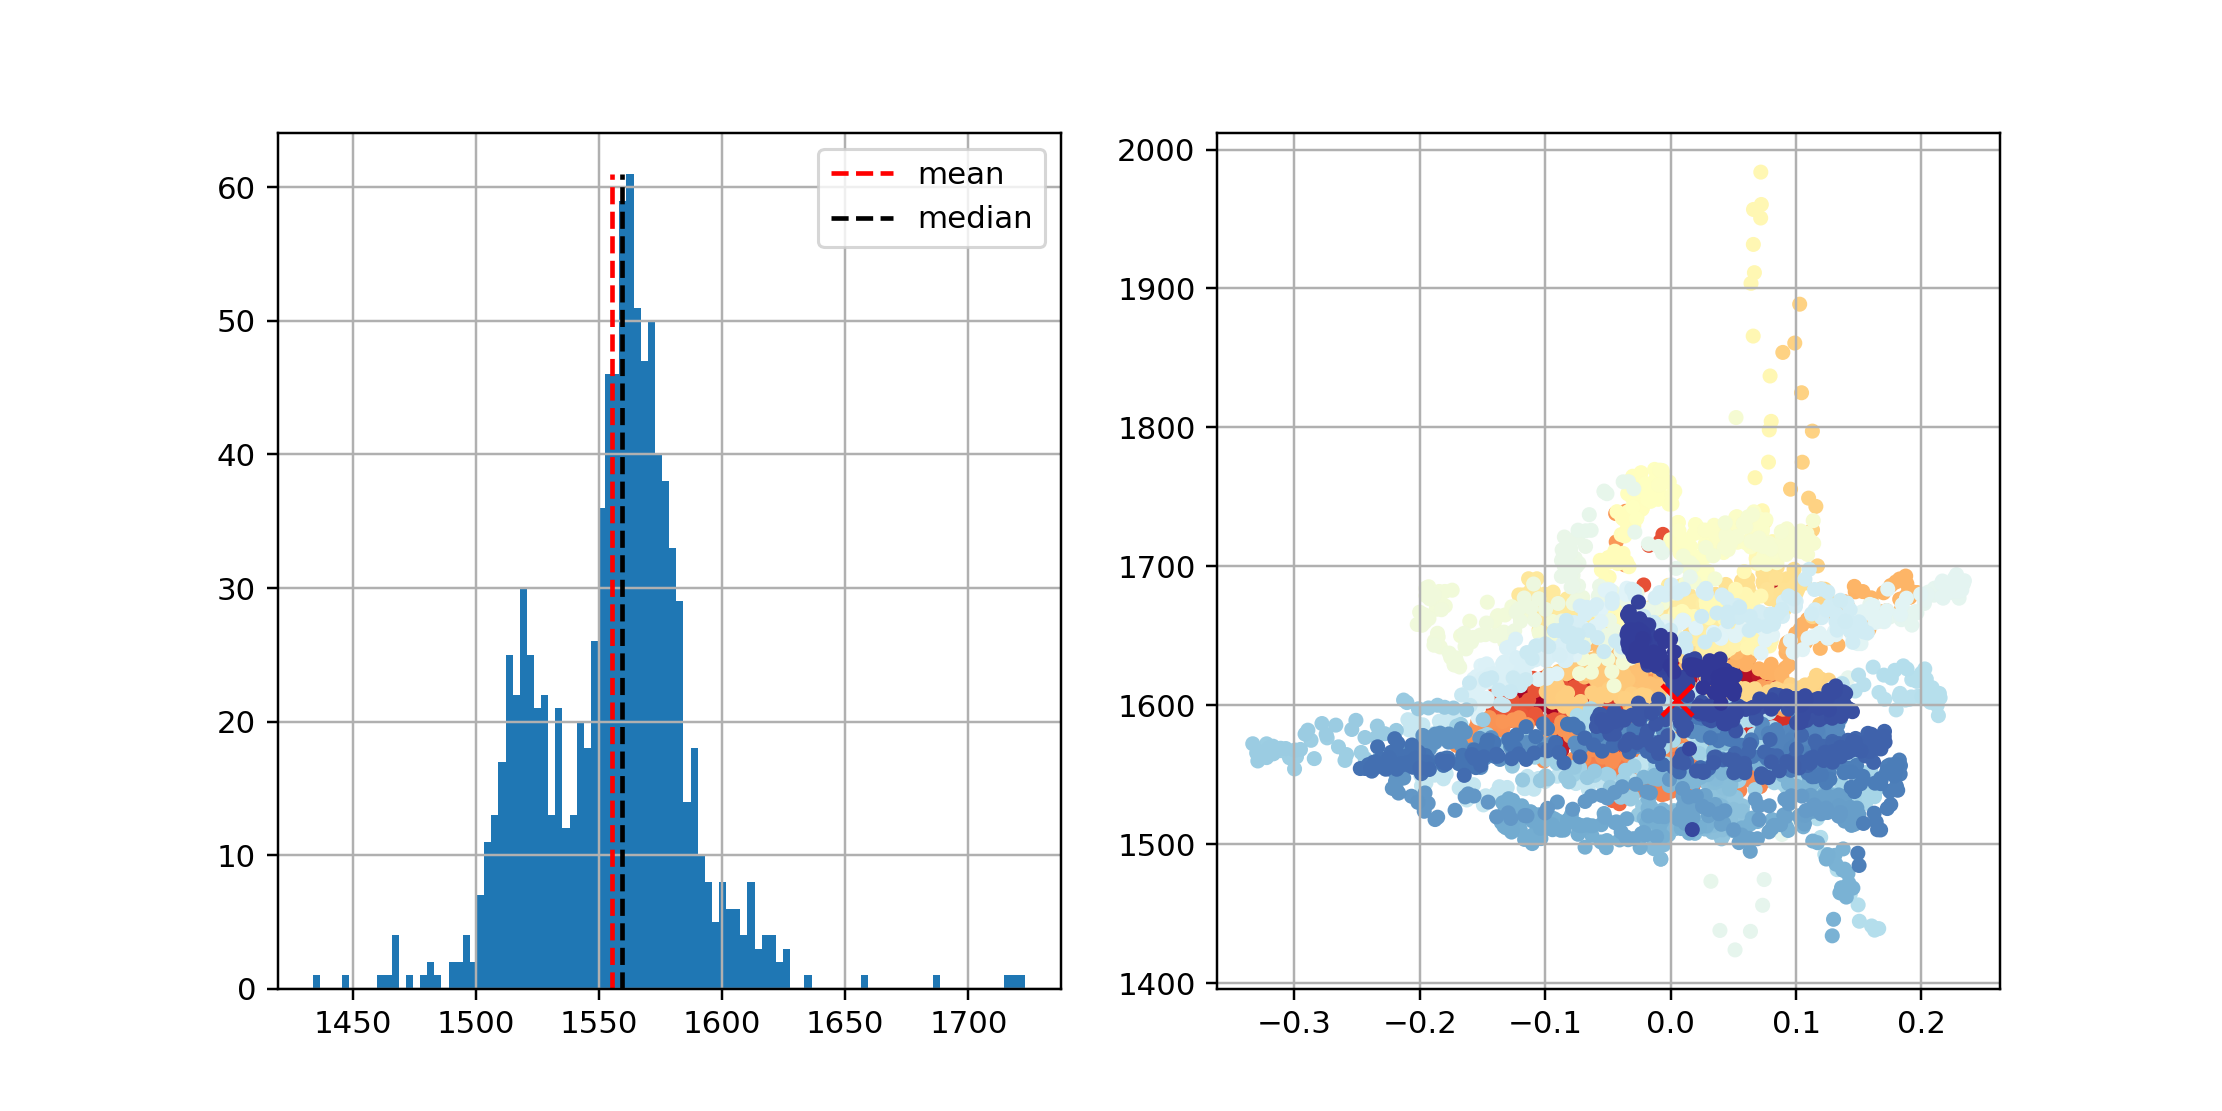

In [83]:
from scipy import stats

fig15, ax15 = plt.subplots(1,2,figsize=(10,5))

value = total_power[delta0==-0.4].values

n, bins, _ = ax15[0].hist(value, bins=100)

ax15[0].plot([np.mean(value), np.mean(value)],[0, max(n)], 'r--', label='mean')
ax15[0].plot([np.median(value), np.median(value)],[0, max(n)], 'k--', label='median')
#ax15.plot([stats.mode(value).mode, stats.mode(value).mode],[0, 50], 'r--')
ax15[0].grid()
ax15[0].legend()

var = u
cm = plt.cm.get_cmap('RdYlBu')

ax15[1].scatter(var[hover], total_power.values[hover], c=range(var[hover].size), s=15, cmap=cm)
ax15[1].scatter(np.mean(var[hover]), np.mean(total_power.values[hover]), marker='x', color='r', s=100)
ax15[1].grid()